In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import tikzplotlib as tpl

In [2]:
from scipy.special import gamma
from scipy.linalg import expm, sqrtm, logm
from scipy.stats import multivariate_normal as mv_norm
from scipy.stats import wishart, chi2

%matplotlib inline

In [3]:
def is_pos_def(x):
    eig = np.linalg.eigvals(x)
    pd = np.all(eig > 0)
    if not pd:
        raise(ValueError("matrix is not positive definite! Matrix: {}; Eigenvalues: {}".format(x, eig)))
    else:
        return(True)
    
def my_kron_product(A, B):
    m_1, n_1 = A.shape[0], A.shape[1]
    m_2, n_2 = B.shape[0], B.shape[1]
    K = np.zeros((m_1*m_2, n_1*n_2))
    for i in range(m_1):
        for j in range(m_2):
            for k in range(n_1):
                for l in range(n_2):
                    K[i*m_2 +j, k*n_2 + l] = A[i,k] * B[j,l]
    
    return(K)
    
def my_box_product(A, B):
    m_1, n_1 = A.shape[0], A.shape[1]
    m_2, n_2 = B.shape[0], B.shape[1]
    K = np.zeros((m_1*m_2, n_1*n_2))
    for i in range(m_1):
        for j in range(m_2):
            for k in range(n_1):
                for l in range(n_2):
                    K[i*m_2 +j, k*n_1 + l] = A[i,l] * B[j,k]
    
    return(K)

# return a cut through a 2D psd_cone, given values for the 
# a_11 and a_22 position of the matrix and a constant rho
def make_2D_psd_cone_cut(a_11, a_22, rho):
    xx = []
    
    for i in range(len(a_11)):
        a_12 = rho*np.sqrt(a_11[i] * a_22[i])
        matrix = np.array([[a_11[i], a_12],[a_12, a_22[i]]])
        is_pos_def(matrix)
        xx.append(matrix)
        
    return(xx)

def multi_variate_gamma(p, a):
    a = np.pi**(p*(p-1)/4) 
    b = np.prod([gamma(a + (1-j)/2) for j in range(1, p + 1)])
    return(a*b)

def create_spd_matrix(p=2, eps=10e-3):
    
    #create two symmetric positive-definite matrices
    X_ = torch.rand(p,p)
    X_sym = (X_ + X_.T)/2
    lambda_X_min = torch.abs(torch.min(torch.eig(X_sym, False)[0])) + eps
    X_spd = X_sym + torch.eye(p) * lambda_X_min
    print("X_spd is spd: ", is_pos_def(X_spd))
    
    return(X_spd.cpu().numpy())

    

(301, 2, 2)
(301,)


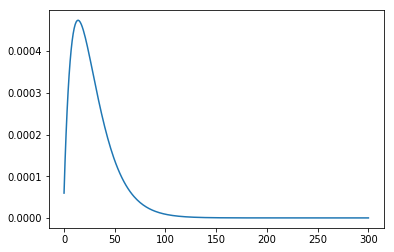

In [4]:
# test the make_2D_psd_cone_cut function
a_11 = np.linspace(0.1, 30.1, 300 +1)
a_22 = np.linspace(0.1, 60.1, 300 +1)
rho = 0

s = np.array([[4,2],
             [2,3]])
is_pos_def(s)

xx = make_2D_psd_cone_cut(a_11, a_22, rho)

w = []
print(np.shape(xx))
for x in xx:
    w_ = wishart.pdf(x, df=4, scale=s)
    w.append(w_)
print(np.shape(w))

plt.plot(w);
plt.show()

# Wishart Distribution Laplace Propagation

In [5]:
#### WARNING: these implementations are not yet optimized for performance. ########

def wishart_pdf(X, n, V):
    p = np.shape(X)[0]
    nom = np.linalg.det(X)**((n-p-1)/2) * np.exp(-np.trace(np.linalg.inv(V) @ X)/2)
    den = 2**(n*p/2) * np.linalg.det(V)**(n/2) * multi_variate_gamma(p, n/2)
    return(nom/den)

def wishart_pdf_t_sqrtm(X, n, V):
    p = np.shape(X)[0]
    nom = np.linalg.det(X)**(n-p) * np.exp(-np.trace(np.linalg.inv(V) @ (X@X.T))/2) 
    den = 2**(n*p/2) * np.linalg.det(V)**(n/2) * multi_variate_gamma(p, n/2)
    return(nom/den)

def wishart_pdf_t_logm(X, n, V):
    p = np.shape(X)[0]
    nom = np.linalg.det(expm(X))**(n-p+1)/2 * np.exp(-np.trace(np.linalg.inv(V) @ expm(X))/2) 
    den = 2**(n*p/2) * np.linalg.det(V)**(n/2) * multi_variate_gamma(p, n/2)
    return(nom/den)
   
def multivariate_normal_pdf_test(X, mu, Sigma):
    k = np.shape(X)[0]
    a = (2*np.pi)**(-k/2) * np.linalg.det(Sigma)**(-1/2)
    x_mu = (X-mu).reshape(-1)
    b = np.exp(-1/2 * x_mu.T @ np.linalg.inv(Sigma) @ x_mu)
    return(a*b)

def square_mv_normal_back(X, mu, Sigma):
    X_ = sqrtm(X).reshape(-1)
    mu = mu.reshape(-1)
    return(mv_norm.pdf(X_, mu, Sigma) * np.linalg.det(sqrtm(X)))

def log_mv_normal_back(X, mu, Sigma):
    X_ = logm(X).reshape(-1)
    mu = mu.reshape(-1)
    return(mv_norm.pdf(X_, mu, Sigma) * np.linalg.det(np.linalg.inv(X)))

def wishart_mode(n, p, V):
    return((n-p-1) * V)

def wishart_Sigma(n, p, V):
    return(2*(n-p-1) * my_kron_product(V, V))

# sqrtm

def wishart_t_sqrtm_mode(n,p,V):
    return(sqrtm((n-p)*V))

"""
def wishart_t_sqrtm_Sigma(n,p,V):
    V_inv = np.linalg.inv(V)
    V_inv_sqrtm = sqrtm(V_inv)
    I_p = np.eye(p)
    one = my_kron_product(V_inv_sqrtm, V_inv_sqrtm)
    two = -0.5 * my_box_product(V_inv, I_p) + my_box_product(I_p, V_inv)
    return(np.linalg.inv(one + two))
"""

def wishart_t_sqrtm_Sigma(n,p,V):
    V_inv = np.linalg.inv(V)
    V_inv_sqrtm = sqrtm(V_inv)
    I_p = np.eye(p)
    one = np.kron(V_inv_sqrtm, V_inv_sqrtm)
    two = np.kron(I_p, V_inv)
    R = np.linalg.inv(one + two)
    return(R)

# logm

def wishart_t_logm_mode(n, p, V):
    return(logm((n-p+1) * V))

def wishart_t_logm_Sigma(n, p, V):
    return(2/(n-p+1) * np.eye(p**2))
    

In [6]:
mode1 = wishart_t_sqrtm_mode(n=5, p=2, V=s)
print(wishart_t_sqrtm_Sigma(n=5, p=2, V=s))

#print(sym_kron_prod(s, np.eye(2)))
#print(sym_kron_prod(np.eye(2), s))
#print(1/4* sym_kron_prod(sqrtm(s), sqrtm(s)))

[[1.84198285 0.76297428 0.31603429 0.15801715]
 [0.76297428 1.46049571 0.15801715 0.23702572]
 [0.31603429 0.15801715 1.68396571 0.68396571]
 [0.15801715 0.23702572 0.68396571 1.34198285]]


# test zone

In [7]:
def sym_kron_prod(A, B):
    
    n = A.shape[0]
    K = np.zeros((n**2, n**2))
    for k in range(n):
        for i in range(n):
            for j in range(n):
                for l in range(n):
                    x1 = A[i,k]*B[j,l]
                    x2 = A[i,l]*B[j,k]
                    x3 = A[j,k]*B[i,l]
                    x4 = A[j,l]*B[i,k]
                    K[n*k + j, n*i + l] = x1 + x2 + x3 + x4
                     
    return(1/4 * K)

def sym_kron_prod_1(A, B):
    
    n = A.shape[0]
    K = np.zeros((n**2, n**2))
    for k in range(n):
        for i in range(n):
            for j in range(n):
                for l in range(n):
                    x1 = A[i,k]*B[j,l]
                    K[n*k + j, n*i + l] = x1 
                     
    return(K)

def sym_kron_prod_2(A, B):
    
    n = A.shape[0]
    K = np.zeros((n**2, n**2))
    for k in range(n):
        for i in range(n):
            for j in range(n):
                for l in range(n):
                    x2 = A[i,l]*B[j,k]
                    K[n*k + j, n*i + l] = x2 
                     
    return(K)

def sym_kron_prod_3(A, B):
    
    n = A.shape[0]
    K = np.zeros((n**2, n**2))
    for k in range(n):
        for i in range(n):
            for j in range(n):
                for l in range(n):
                    x3 = A[j,k]*B[i,l]
                    K[n*k + j, n*i + l] = x3
                     
    return(K)

def sym_kron_prod_4(A, B):
    
    n = A.shape[0]
    K = np.zeros((n**2, n**2))
    for k in range(n):
        for i in range(n):
            for j in range(n):
                for l in range(n):
                    x4 = A[j,l]*B[i,k]
                    K[n*k + j, n*i + l] = x4
                     
    return(K)


In [8]:
s = np.array([[4,2],
             [2,3]])
is_pos_def(s)

X_test = create_spd_matrix(p=2)
is_pos_def(X_test)

I = np.eye(2)
#print(sym_kron_prod(s, X_test))
#print(1/4*(sym_kron_prod_1(s, X_test) + sym_kron_prod_2(s, X_test) + sym_kron_prod_3(s, X_test) + sym_kron_prod_4(s, X_test)))

print(0.5 * (my_box_product(I, s) + my_box_product(s, I)))
print(0.5 * (sym_kron_prod_1(I, s) + sym_kron_prod_4(I, s)))

X_spd is spd:  True
[[4.  1.  1.  0. ]
 [1.  0.  3.5 1. ]
 [1.  3.5 0.  1. ]
 [0.  1.  1.  3. ]]
[[4.  1.  1.  0. ]
 [1.  3.5 0.  1. ]
 [1.  0.  3.5 1. ]
 [0.  1.  1.  3. ]]


## sqrtm basis

In [9]:
# function that creates a fancy plot for three different values of n
# the plot contains the original Laplace approximation, the Bridge, and a back transform

def plot_Wishart_bridge_sqrtm(xx, xxt, ns, s, filename, p=2, save=False, show_back=True):
    
    n1, n2, n3 = ns
    
    ##### normal laplace
    
    mode1 = wishart_mode(n1, p=p, V=s)
    mode2 = wishart_mode(n2, p=p, V=s)
    mode3 = wishart_mode(n3, p=p, V=s)
    #print("mode1: ", mode1)
    #print("mode2: ", mode2)
    #print("mode3: ", mode3)

    sigma1 = wishart_Sigma(n1, p=p, V=s)
    sigma2 = wishart_Sigma(n2, p=p, V=s)
    sigma3 = wishart_Sigma(n3, p=p, V=s)
    #print("sigma1: ", sigma1)
    #print("sigma2: ", sigma2)
    #print("sigma3: ", sigma3)
    
    is_pos_def(sigma1)
    is_pos_def(sigma2)
    is_pos_def(sigma3)

    w1 = []
    w2 = []
    w3 = []
    normal1 = []
    normal2 = []
    normal3 = []
    
    for x in xx:
        w_1 = wishart_pdf(X=x, n=n1, V=s)
        w_2 = wishart_pdf(X=x, n=n2, V=s)
        w_3 = wishart_pdf(X=x, n=n3, V=s)
        w1.append(w_1)
        w2.append(w_2)
        w3.append(w_3)
        w1_lpa = multivariate_normal_pdf_test(X=x, mu=mode1, Sigma=sigma1)
        w2_lpa = multivariate_normal_pdf_test(X=x, mu=mode2, Sigma=sigma2)
        w3_lpa = multivariate_normal_pdf_test(X=x, mu=mode3, Sigma=sigma3)
        normal1.append(w1_lpa)
        normal2.append(w2_lpa)
        normal3.append(w3_lpa)

    w1 = np.array(w1)
    w2 = np.array(w2)
    w3 = np.array(w3)
    
    rescale_normal1 = np.max(w1)/np.max(normal1)
    rescale_normal2 = np.max(w2)/np.max(normal2)
    rescale_normal3 = np.max(w3)/np.max(normal3)

    normal1 = np.array(normal1) * rescale_normal1
    normal2 = np.array(normal2) * rescale_normal2
    normal3 = np.array(normal3) * rescale_normal3
    

    ######### square transformation

    mode1_t_sqrtm = wishart_t_sqrtm_mode(n1, p=p, V=s)
    mode2_t_sqrtm = wishart_t_sqrtm_mode(n2, p=p, V=s)
    mode3_t_sqrtm = wishart_t_sqrtm_mode(n3, p=p, V=s)

    sigma1_t_sqrtm = wishart_t_sqrtm_Sigma(n1, p=p, V=s)
    sigma2_t_sqrtm = wishart_t_sqrtm_Sigma(n2, p=p, V=s)
    sigma3_t_sqrtm = wishart_t_sqrtm_Sigma(n3, p=p, V=s)

    is_pos_def(sigma1_t_sqrtm)
    is_pos_def(sigma2_t_sqrtm)
    is_pos_def(sigma3_t_sqrtm)

    w1_t_sqrtm = []
    w2_t_sqrtm = []
    w3_t_sqrtm = []
    w1_lpa_t_sqrtm = []
    w2_lpa_t_sqrtm = []
    w3_lpa_t_sqrtm = []

    for x in xxt:
        w_1 = wishart_pdf_t_sqrtm(X=x, n=n1, V=s)
        w_2 = wishart_pdf_t_sqrtm(X=x, n=n2, V=s)
        w_3 = wishart_pdf_t_sqrtm(X=x, n=n3, V=s)
        w1_t_sqrtm.append(w_1)
        w2_t_sqrtm.append(w_2)
        w3_t_sqrtm.append(w_3)
        #
        w1_lpa = multivariate_normal_pdf_test(X=x, mu=mode1_t_sqrtm, Sigma=sigma1_t_sqrtm)
        w2_lpa = multivariate_normal_pdf_test(X=x, mu=mode2_t_sqrtm, Sigma=sigma2_t_sqrtm)
        w3_lpa = multivariate_normal_pdf_test(X=x, mu=mode3_t_sqrtm, Sigma=sigma3_t_sqrtm)
        w1_lpa_t_sqrtm.append(w1_lpa)
        w2_lpa_t_sqrtm.append(w2_lpa)
        w3_lpa_t_sqrtm.append(w3_lpa)

    #rescale for visibility
    w1_t_sqrtm = np.array(w1_t_sqrtm)
    w2_t_sqrtm = np.array(w2_t_sqrtm)
    w3_t_sqrtm = np.array(w3_t_sqrtm)
    
    rescale1_t_sqrtm = np.max(w1_t_sqrtm)/np.max(w1_lpa_t_sqrtm)
    rescale2_t_sqrtm = np.max(w2_t_sqrtm)/np.max(w2_lpa_t_sqrtm)
    rescale3_t_sqrtm = np.max(w3_t_sqrtm)/np.max(w3_lpa_t_sqrtm)

    w1_lpa_t_sqrtm = np.array(w1_lpa_t_sqrtm) * rescale1_t_sqrtm
    w2_lpa_t_sqrtm = np.array(w2_lpa_t_sqrtm) * rescale2_t_sqrtm
    w3_lpa_t_sqrtm = np.array(w3_lpa_t_sqrtm) * rescale3_t_sqrtm 

    ######### back transform #########

    w1_back = []
    w2_back = []
    w3_back = []

    for x in xx:
        w1_back.append(square_mv_normal_back(x, mode1_t_sqrtm, sigma1_t_sqrtm))
        w2_back.append(square_mv_normal_back(x, mode2_t_sqrtm, sigma2_t_sqrtm))
        w3_back.append(square_mv_normal_back(x, mode3_t_sqrtm, sigma3_t_sqrtm))
        
    rescale_back1 = np.max(w1)/np.max(w1_back)
    rescale_back2 = np.max(w2)/np.max(w2_back)
    rescale_back3 = np.max(w3)/np.max(w3_back)

    w1_back = np.array(w1_back) * rescale_back1
    w2_back = np.array(w2_back) * rescale_back2 
    w3_back = np.array(w3_back) * rescale_back3 
    
    """Plots"""
    plt.rcParams['xtick.labelsize'] = 20
    plt.rcParams['ytick.labelsize'] = 20
    plt.rcParams["font.family"] = "serif"
    plt.rcParams["font.serif"] = "Times New Roman"
    legend_size=25
    xlabel_size=25
    ylabel_size=25
    title_size=25
    lw = 3

    if show_back:
        fig, axs = plt.subplots(nrows=1, ncols=3, sharex=False, figsize=(26,6))
    else:
        fig, axs = plt.subplots(nrows=1, ncols=2, sharex=False, figsize=(20,4))
        
    axs[0].plot(w1, 'r-', lw=lw)
    axs[0].plot(w2, 'b-', lw=lw)
    axs[0].plot(w3, 'k-', lw=lw, label="$\mathcal{W}$")
    axs[0].plot(normal1, 'r--', lw=lw)
    axs[0].plot(normal2, 'b--', lw=lw)
    axs[0].plot(normal3, 'k--', lw=lw, label="$\mathcal{N}$")
    axs[0].set_yticklabels([])
    axs[0].set_yticks([])
    axs[0].set_xlabel('$g(x)$', fontsize=xlabel_size)
    axs[0].set_ylabel('$p(g(x))dg(x)$', fontsize=ylabel_size)
    axs[0].set_title('Laplace in standard basis', fontsize=title_size)
    axs[0].legend(prop={'size': legend_size});

    axs[1].plot(w1_t_sqrtm, 'r', lw=lw)
    axs[1].plot(w2_t_sqrtm, 'b', lw=lw)
    axs[1].plot(w3_t_sqrtm, 'k', lw=lw, label="$\mathcal{W}$")
    axs[1].plot(w1_lpa_t_sqrtm, 'r--', lw=lw)
    axs[1].plot(w2_lpa_t_sqrtm, 'b--', lw=lw)
    axs[1].plot(w3_lpa_t_sqrtm, 'k--', lw=lw, label="$\mathcal{N}$")
    #axs[1].set_yticklabels([])
    #axs[1].set_yticks([])
    axs[1].set_xlabel('$g(x)$', fontsize=xlabel_size)
    axs[1].set_ylabel('$p(g(x))dg(x)$', fontsize=ylabel_size)
    axs[1].set_title('Laplace in sqrtm basis', fontsize=title_size)
    axs[1].legend(prop={'size': legend_size});

    if show_back:
        axs[2].plot(w1, 'r-', lw=lw)
        axs[2].plot(w2, 'b-', lw=lw)
        axs[2].plot(w3, 'k-', lw=lw, label="$\mathcal{W}$")
        axs[2].plot(w1_back, 'r--', lw=lw)
        axs[2].plot(w2_back, 'b--', lw=lw)
        axs[2].plot(w3_back, 'k--', lw=lw, label="$\mathcal{N}$")
        axs[2].set_yticklabels([])
        axs[2].set_yticks([])
        axs[2].set_xlabel('$g(x)$', fontsize=xlabel_size)
        axs[2].set_ylabel('$p(g(x))dg(x)$', fontsize=ylabel_size)
        axs[2].set_title('Back to standard basis', fontsize=title_size)
        axs[2].legend(prop={'size': legend_size});
    
    plt.tight_layout()

    if save:
        plt.savefig(filename)
    plt.show();

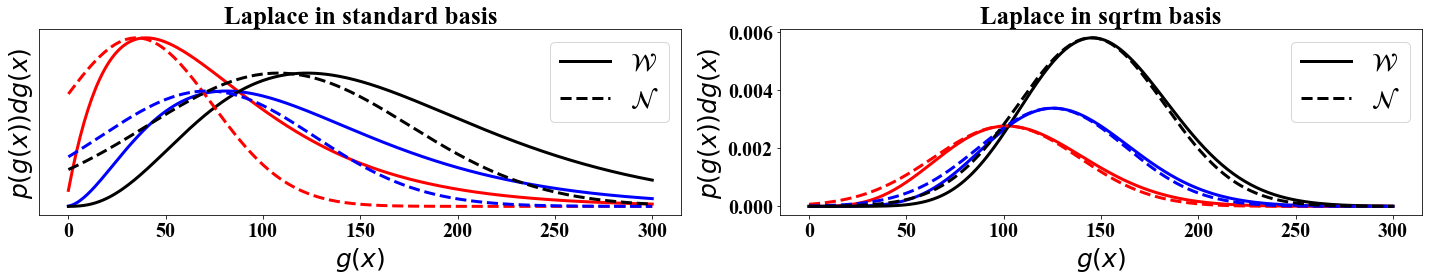

In [10]:
# test the function for one value of rho and s

""" values """
a_11 = np.linspace(0.1, 20.1, 300 +1)
a_22 = np.linspace(0.1, 20.1, 300 +1)

a_11_t = np.linspace(0.1, 7.1, 300 +1)
a_22_t = np.linspace(0.1, 7.1, 300 +1)

s = np.array([[4,2],
             [2,3]])

#s = np.array([[5,3],
#             [3,4]])

#s = 2*np.eye(2)
is_pos_def(s)

r = 0.3
xx = make_2D_psd_cone_cut(a_11, a_22, r)
xxt = make_2D_psd_cone_cut(a_11_t, a_22_t, r)

n1 = 4
n2 = 5
n3 = 6

p=2

plot_Wishart_bridge_sqrtm(xx=xx, xxt=xxt, ns=[n1,n2,n3], s=s, p=2, save=False, filename='wishart_sqrtm_bridge.pdf', show_back=False)

-0.9


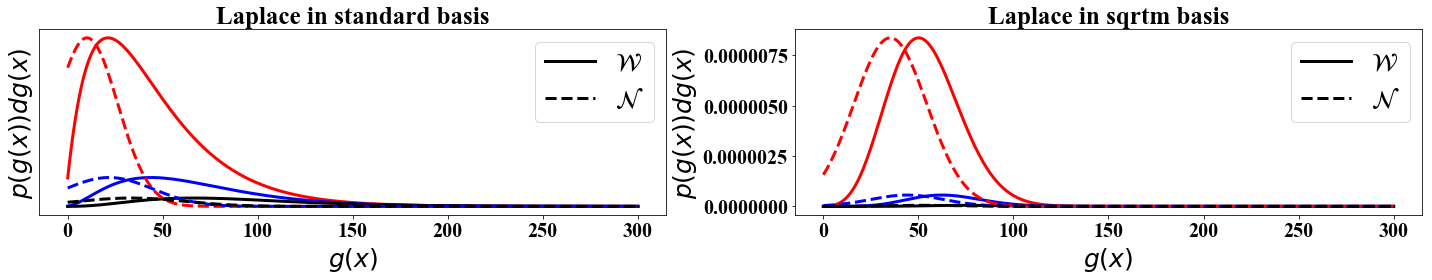

-0.8


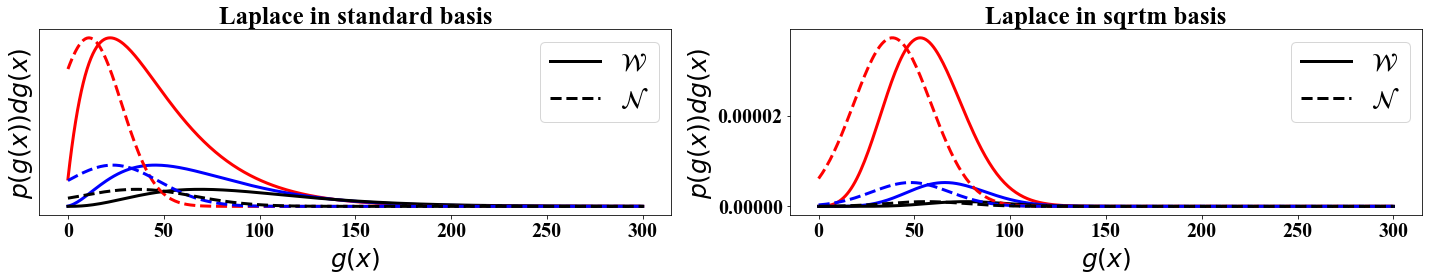

-0.7


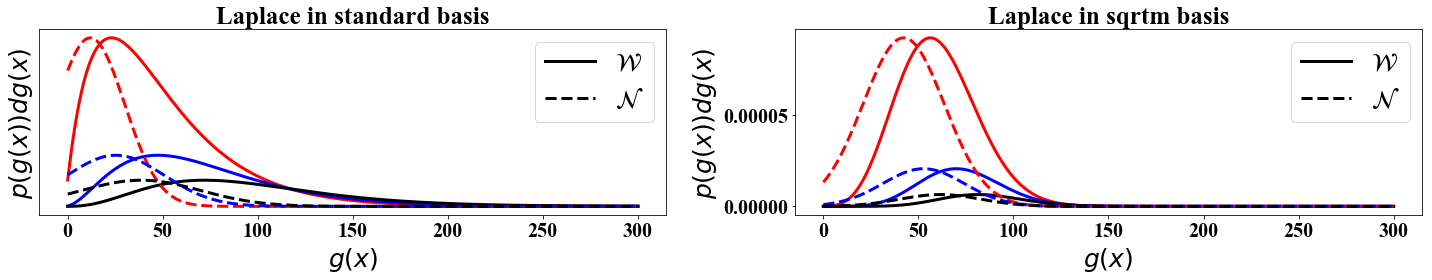

-0.6


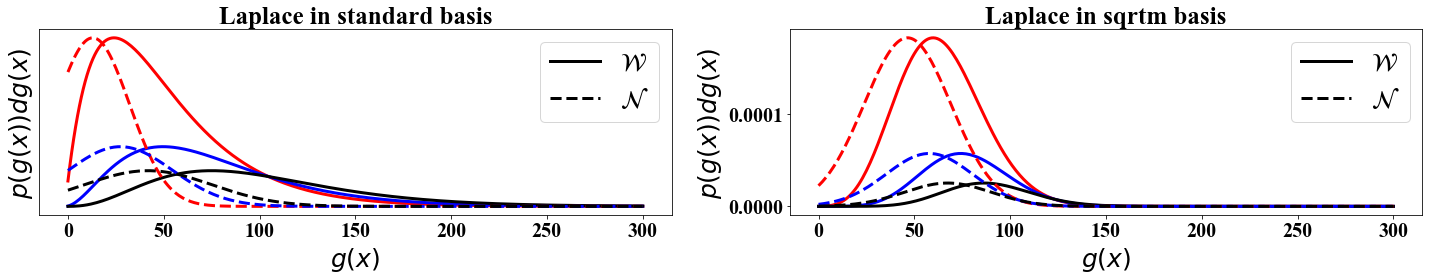

-0.5


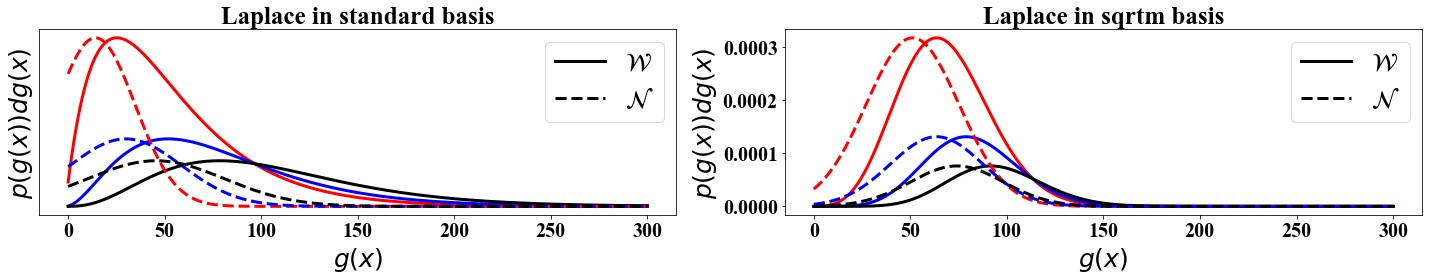

-0.4


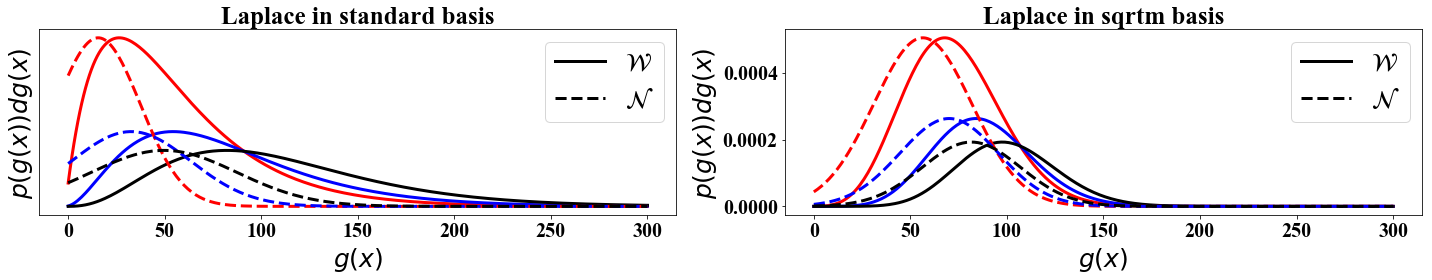

-0.29999999999999993


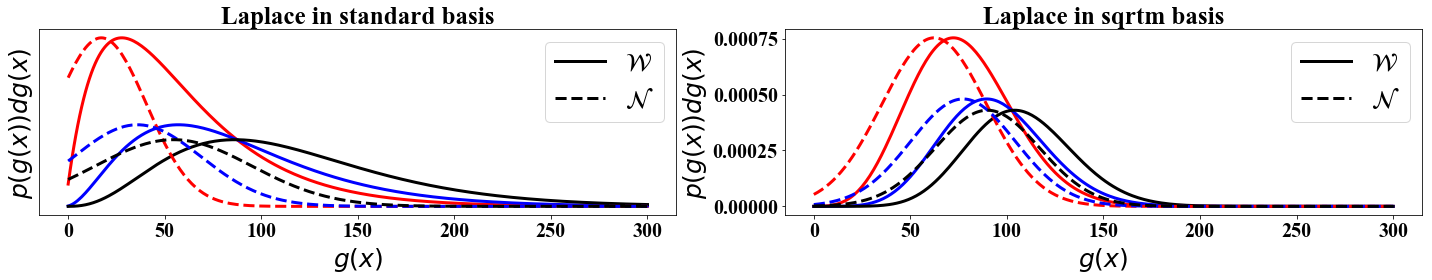

-0.19999999999999996


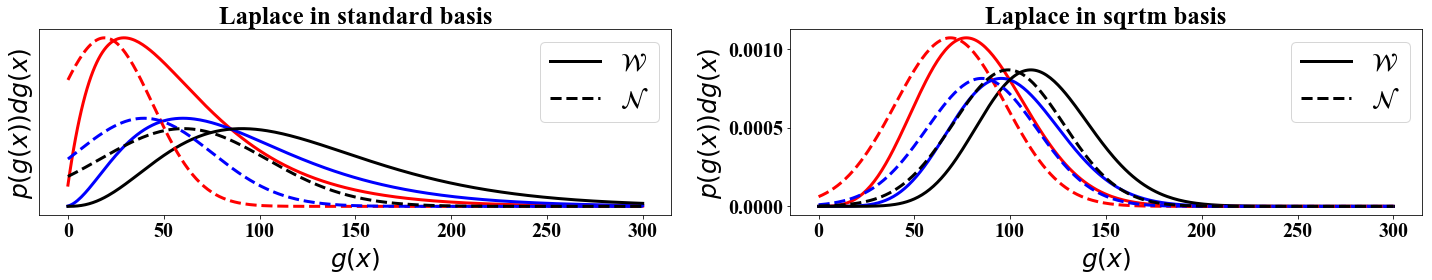

-0.09999999999999998


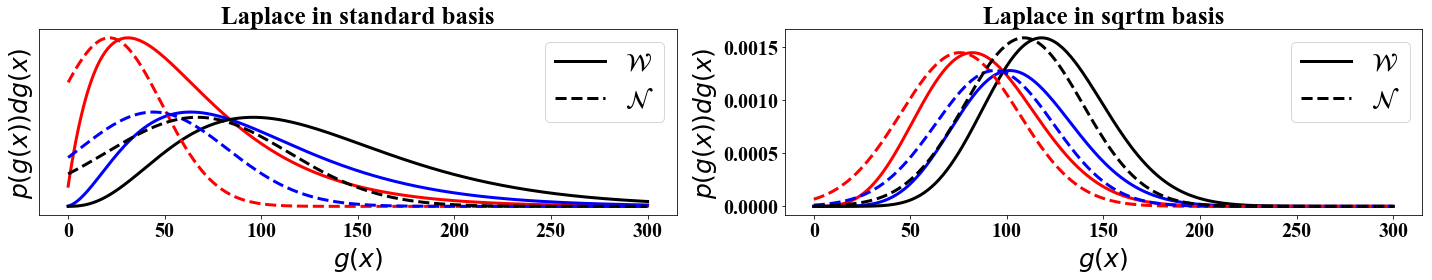

0.0


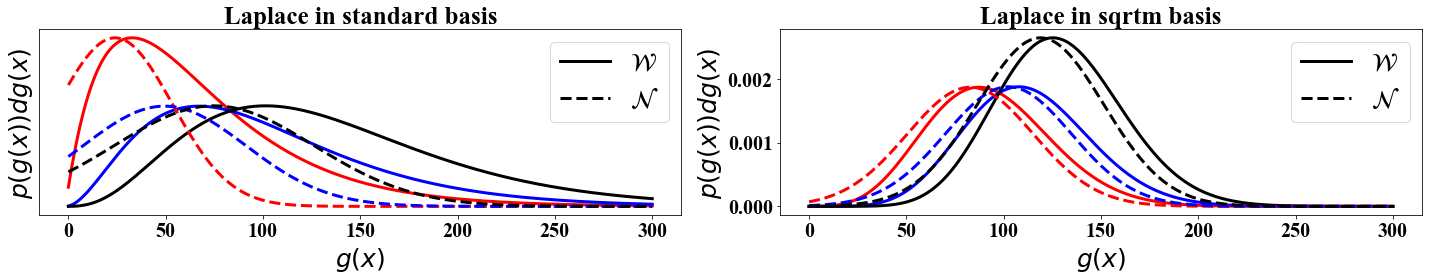

0.09999999999999998


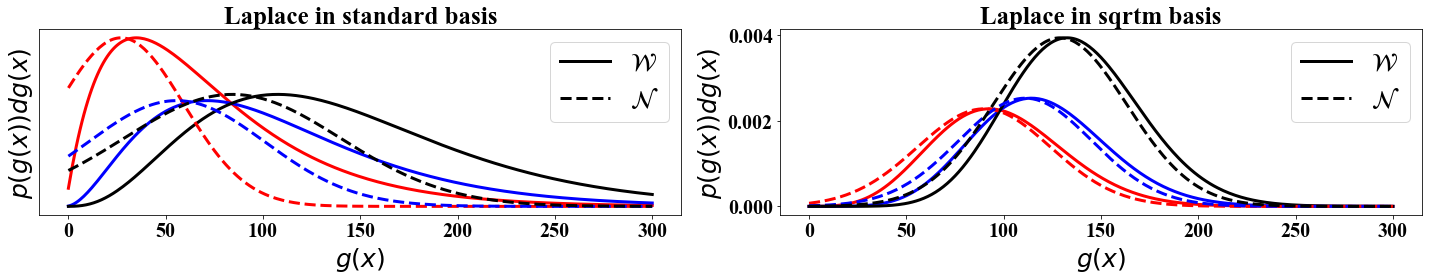

0.20000000000000007


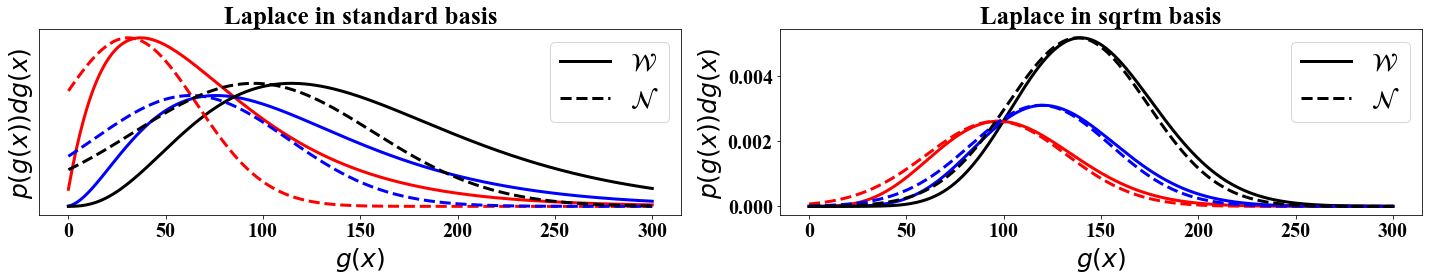

0.30000000000000016


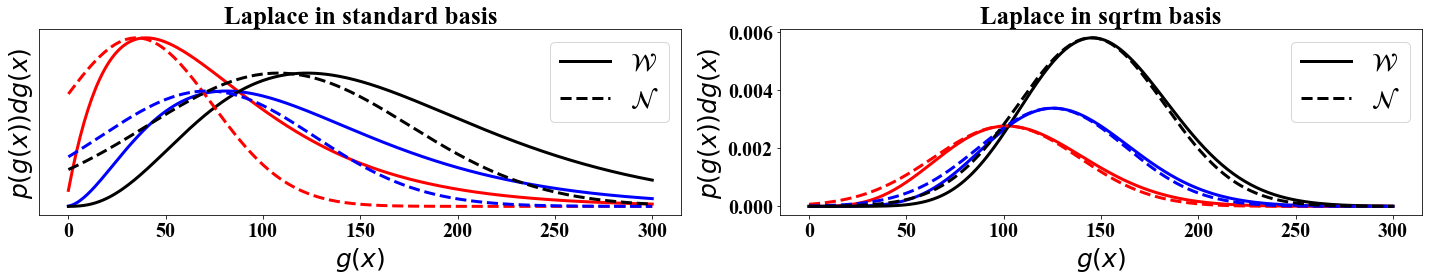

0.4


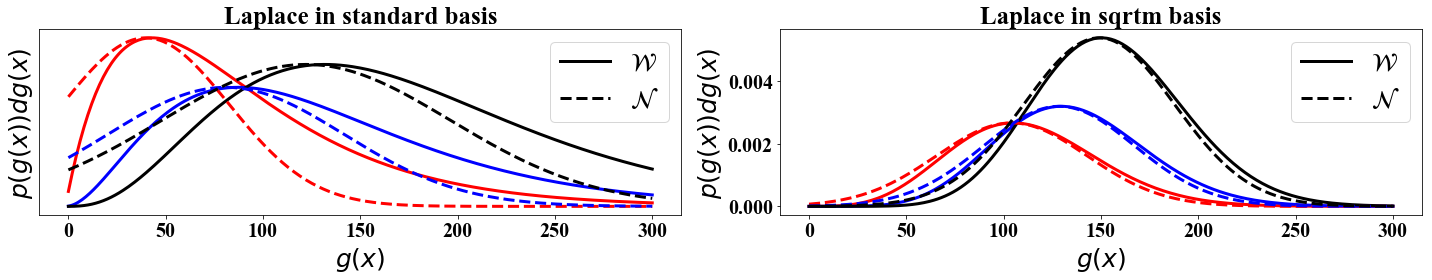

0.5000000000000001


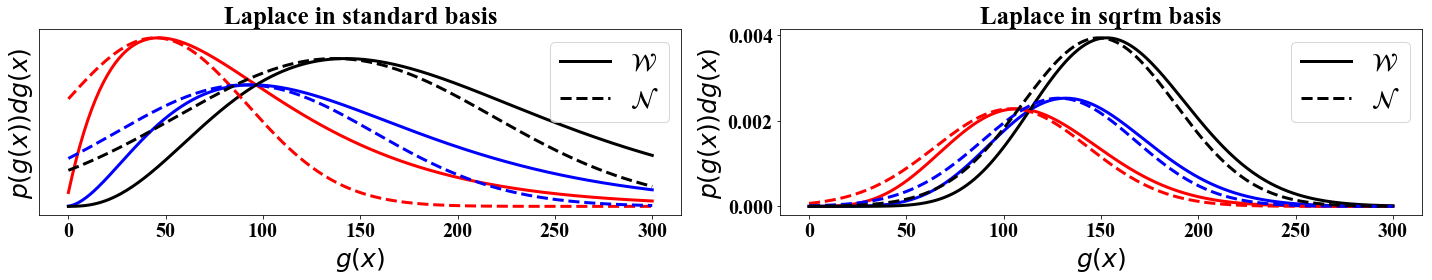

0.6


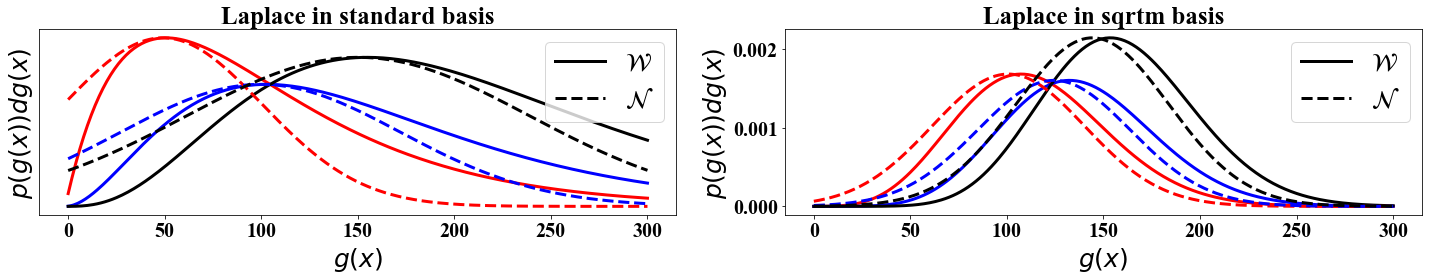

0.7000000000000001


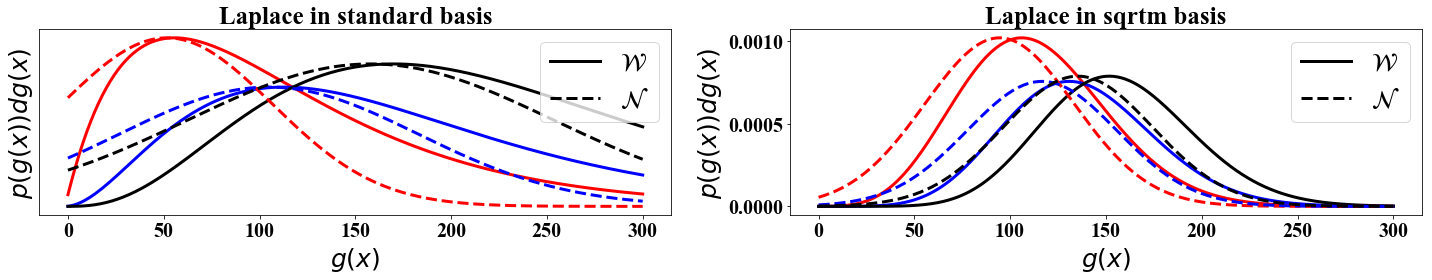

0.8000000000000002


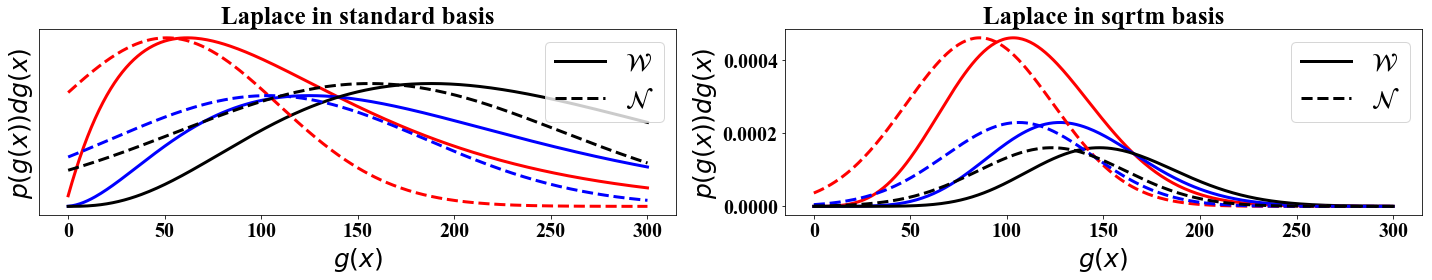

0.9


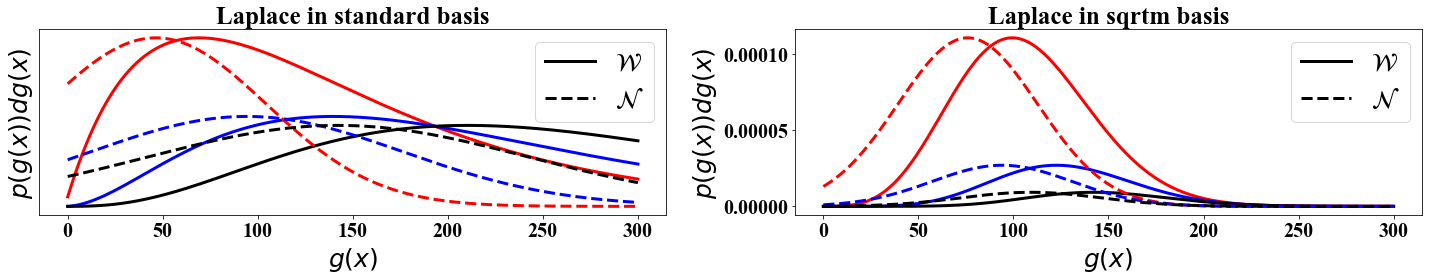

In [11]:
# test the function for multiple values of rho and s

""" values """

#s = np.eye(2)*2

s = np.array([[4,2],
             [2,3]])

#s = np.array([[5,3],
#             [3,4]])

n1 = 4
n2 = 5
n3 = 6

p=2

rhos = np.linspace(-0.9, 0.9, 19)

for r in rhos:
    
    print(r)
    xx = make_2D_psd_cone_cut(a_11, a_22, r)
    xxt = make_2D_psd_cone_cut(a_11_t, a_22_t, r)
    plot_Wishart_bridge_sqrtm(xx=xx, xxt=xxt, ns=[n1,n2,n3], s=s, p=2, save=False, filename='', show_back=False)

## logm basis

In [12]:
def wishart_t_logm_mode(n, p, V):
    #return(logm((n-p+5) * V))
    return(logm(2*(n-p+1) * V))

In [13]:
# function that creates a fancy plot for three different values of n
# the plot contains the original Laplace approximation, the Bridge, and a back transform

def plot_Wishart_bridge_logm(xx, xxt, ns, s, filename, p=2, save=False, show_back=True):
    
    n1, n2, n3 = ns
    
    ##### normal laplace
    
    mode1 = wishart_mode(n1, p=p, V=s)
    mode2 = wishart_mode(n2, p=p, V=s)
    mode3 = wishart_mode(n3, p=p, V=s)
    #print("mode1: ", mode1)
    #print("mode2: ", mode2)
    #print("mode3: ", mode3)

    sigma1 = wishart_Sigma(n1, p=p, V=s)
    sigma2 = wishart_Sigma(n2, p=p, V=s)
    sigma3 = wishart_Sigma(n3, p=p, V=s)
    #print("sigma1: ", sigma1)
    #print("sigma2: ", sigma2)
    #print("sigma3: ", sigma3)
    
    is_pos_def(sigma1)
    is_pos_def(sigma2)
    is_pos_def(sigma3)

    w1 = []
    w2 = []
    w3 = []
    normal1 = []
    normal2 = []
    normal3 = []

    print(np.shape(xx))
    for x in xx:
        w_1 = wishart_pdf(X=x, n=n1, V=s)
        w_2 = wishart_pdf(X=x, n=n2, V=s)
        w_3 = wishart_pdf(X=x, n=n3, V=s)
        w1.append(w_1)
        w2.append(w_2)
        w3.append(w_3)
        w1_lpa = multivariate_normal_pdf_test(X=x, mu=mode1, Sigma=sigma1)
        w2_lpa = multivariate_normal_pdf_test(X=x, mu=mode2, Sigma=sigma2)
        w3_lpa = multivariate_normal_pdf_test(X=x, mu=mode3, Sigma=sigma3)
        normal1.append(w1_lpa)
        normal2.append(w2_lpa)
        normal3.append(w3_lpa)

    w1 = np.array(w1)
    w2 = np.array(w2)
    w3 = np.array(w3)
    
    rescale_normal1 = np.max(w1)/np.max(normal1)
    rescale_normal2 = np.max(w2)/np.max(normal2)
    rescale_normal3 = np.max(w3)/np.max(normal3)

    normal1 = np.array(normal1) * rescale_normal1
    normal2 = np.array(normal2) * rescale_normal2
    normal3 = np.array(normal3) * rescale_normal3
    

    ######### logm transformation

    mode1_t_logm = wishart_t_logm_mode(n1, p=p, V=s)
    mode2_t_logm = wishart_t_logm_mode(n2, p=p, V=s)
    mode3_t_logm = wishart_t_logm_mode(n3, p=p, V=s)

    sigma1_t_logm = wishart_t_logm_Sigma(n1, p=p, V=s)
    sigma2_t_logm = wishart_t_logm_Sigma(n2, p=p, V=s)
    sigma3_t_logm = wishart_t_logm_Sigma(n3, p=p, V=s)

    is_pos_def(sigma1_t_logm)
    is_pos_def(sigma2_t_logm)
    is_pos_def(sigma3_t_logm)

    w1_t_logm = []
    w2_t_logm = []
    w3_t_logm = []
    w1_lpa_t_logm = []
    w2_lpa_t_logm = []
    w3_lpa_t_logm = []

    for x in xxt:
        w_1 = wishart_pdf_t_logm(X=x, n=n1, V=s)
        w_2 = wishart_pdf_t_logm(X=x, n=n2, V=s)
        w_3 = wishart_pdf_t_logm(X=x, n=n3, V=s)
        w1_t_logm.append(w_1)
        w2_t_logm.append(w_2)
        w3_t_logm.append(w_3)
        #
        w1_lpa = multivariate_normal_pdf_test(X=x, mu=mode1_t_logm, Sigma=sigma1_t_logm)
        w2_lpa = multivariate_normal_pdf_test(X=x, mu=mode2_t_logm, Sigma=sigma2_t_logm)
        w3_lpa = multivariate_normal_pdf_test(X=x, mu=mode3_t_logm, Sigma=sigma3_t_logm)
        w1_lpa_t_logm.append(w1_lpa)
        w2_lpa_t_logm.append(w2_lpa)
        w3_lpa_t_logm.append(w3_lpa)

    #rescale for visibility
    w1_t_logm = np.array(w1_t_logm)
    w2_t_logm = np.array(w2_t_logm)
    w3_t_logm = np.array(w3_t_logm)
    
    rescale1_t_logm = np.max(w1_t_logm)/np.max(w1_lpa_t_logm)
    rescale2_t_logm = np.max(w2_t_logm)/np.max(w2_lpa_t_logm)
    rescale3_t_logm = np.max(w3_t_logm)/np.max(w3_lpa_t_logm)

    w1_lpa_t_logm = np.array(w1_lpa_t_logm) * rescale1_t_logm
    w2_lpa_t_logm = np.array(w2_lpa_t_logm) * rescale2_t_logm
    w3_lpa_t_logm = np.array(w3_lpa_t_logm) * rescale3_t_logm

    ######### back transform #########

    w1_back = []
    w2_back = []
    w3_back = []

    for x in xx:
        w1_back.append(log_mv_normal_back(x, mode1_t_logm, sigma1_t_logm))
        w2_back.append(log_mv_normal_back(x, mode2_t_logm, sigma2_t_logm))
        w3_back.append(log_mv_normal_back(x, mode3_t_logm, sigma3_t_logm))
        
    rescale_back1 = np.max(w1)/np.max(w1_back)
    rescale_back2 = np.max(w2)/np.max(w2_back)
    rescale_back3 = np.max(w3)/np.max(w3_back)

    w1_back = np.array(w1_back) * rescale_back1
    w2_back = np.array(w2_back) * rescale_back2 
    w3_back = np.array(w3_back) * rescale_back3 

    """Plots"""
    plt.rcParams['xtick.labelsize'] = 20
    plt.rcParams['ytick.labelsize'] = 20
    plt.rcParams["font.family"] = "serif"
    plt.rcParams["font.serif"] = "Times New Roman"
    legend_size=25
    xlabel_size=25
    ylabel_size=25
    title_size=25
    lw = 3

    if show_back:
        fig, axs = plt.subplots(nrows=1, ncols=3, sharex=False, figsize=(26,6))
    else:
        fig, axs = plt.subplots(nrows=1, ncols=2, sharex=False, figsize=(20,4))
        
    axs[0].plot(w1, 'r-', lw=lw)
    axs[0].plot(w2, 'b-', lw=lw)
    axs[0].plot(w3, 'k-', lw=lw, label="$\mathcal{W}$")
    axs[0].plot(normal1, 'r--', lw=lw)
    axs[0].plot(normal2, 'b--', lw=lw)
    axs[0].plot(normal3, 'k--', lw=lw, label="$\mathcal{N}$")
    #axs[0].set_yticklabels([])
    #axs[0].set_yticks([])
    axs[0].set_xlabel('$g(x)$', fontsize=xlabel_size)
    axs[0].set_ylabel('$p(g(x))dg(x)$', fontsize=ylabel_size)
    axs[0].set_title('Laplace in standard basis', fontsize=title_size)
    axs[0].legend(prop={'size': legend_size});

    axs[1].plot(w1_t_logm, 'r', lw=lw)
    axs[1].plot(w2_t_logm, 'b', lw=lw)
    axs[1].plot(w3_t_logm, 'k', lw=lw, label="$\mathcal{W}$")
    axs[1].plot(w1_lpa_t_logm, 'r--', lw=lw)
    axs[1].plot(w2_lpa_t_logm, 'b--', lw=lw)
    axs[1].plot(w3_lpa_t_logm, 'k--', lw=lw, label="$\mathcal{N}$")
    #axs[1].set_yticklabels([])
    #axs[1].set_yticks([])
    axs[1].set_xlabel('$g(x)$', fontsize=xlabel_size)
    axs[1].set_ylabel('$p(g(x))dg(x)$', fontsize=ylabel_size)
    axs[1].set_title('Laplace in logm basis', fontsize=title_size)
    axs[1].legend(prop={'size': legend_size});

    if show_back:
        axs[2].plot(w1, 'r-', lw=lw)
        axs[2].plot(w2, 'b-', lw=lw)
        axs[2].plot(w3, 'k-', lw=lw, label="$\mathcal{W}$")
        axs[2].plot(w1_back, 'r--', lw=lw)
        axs[2].plot(w2_back, 'b--', lw=lw)
        axs[2].plot(w3_back, 'k--', lw=lw, label="$\mathcal{N}$")
        axs[2].set_yticklabels([])
        axs[2].set_yticks([])
        axs[2].set_xlabel('$g(x)$', fontsize=xlabel_size)
        axs[2].set_ylabel('$p(g(x))dg(x)$', fontsize=ylabel_size)
        axs[2].set_title('Back to standard basis', fontsize=title_size)
        axs[2].legend(prop={'size': legend_size});
    
    plt.tight_layout()

    if save:
        plt.savefig(filename)
    plt.show();

[[2. 0.]
 [0. 2.]]
(301, 2, 2)


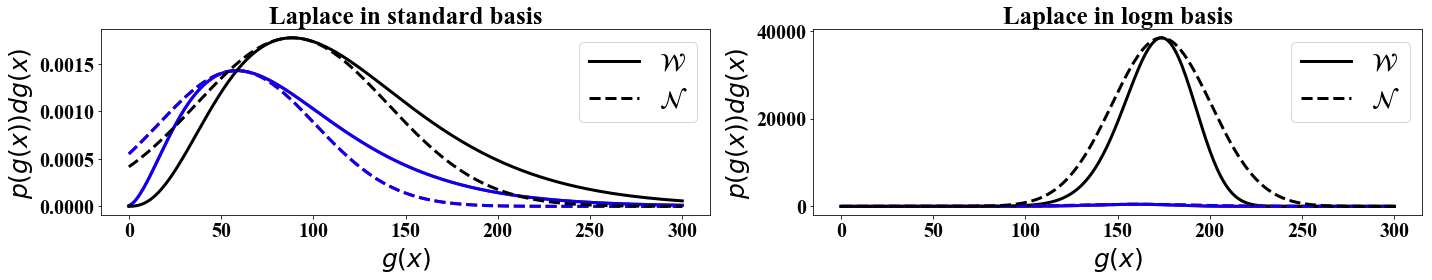

In [14]:
# test the function for one value of rho and s

""" values """
a_11 = np.linspace(0.1, 20.1, 300 +1)
a_22 = np.linspace(0.1, 20.1, 300 +1)

a_11_t = np.linspace(0.1, 5.1, 300 +1)
a_22_t = np.linspace(0.1, 5.1, 300 +1)

#s = np.array([[4,2],
#             [2,3]])

#s = np.array([[5,3],
#             [3,4]])

s = 2*np.eye(2)

#s = create_spd_matrix(eps=3)
print(s)

is_pos_def(s)

r = 0.0
xx = make_2D_psd_cone_cut(a_11, a_22, r)
xxt = make_2D_psd_cone_cut(a_11_t, a_22_t, r)

n1 = 5
n2 = 5
n3 = 6

p=2

plot_Wishart_bridge_logm(xx=xx, xxt=xxt, ns=[n1,n2,n3], s=s, p=2, save=True, 
                         filename='wishart_logm_bridge.pdf', show_back=False)


-0.9
(301, 2, 2)


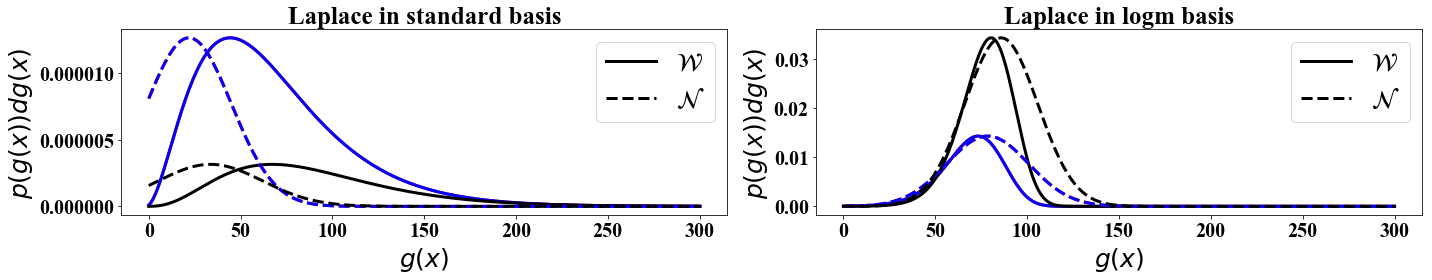

-0.8
(301, 2, 2)


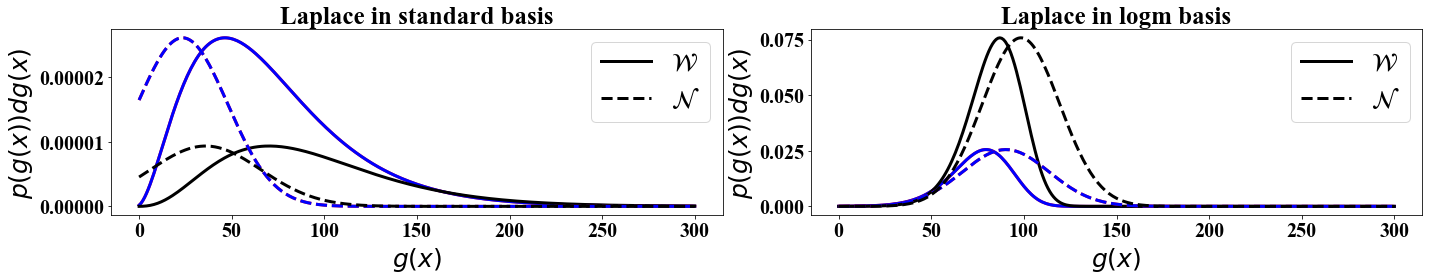

-0.7
(301, 2, 2)


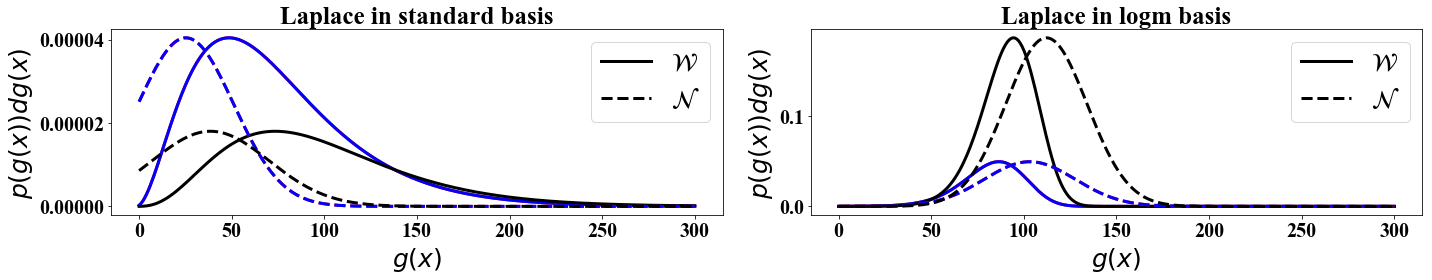

-0.6
(301, 2, 2)


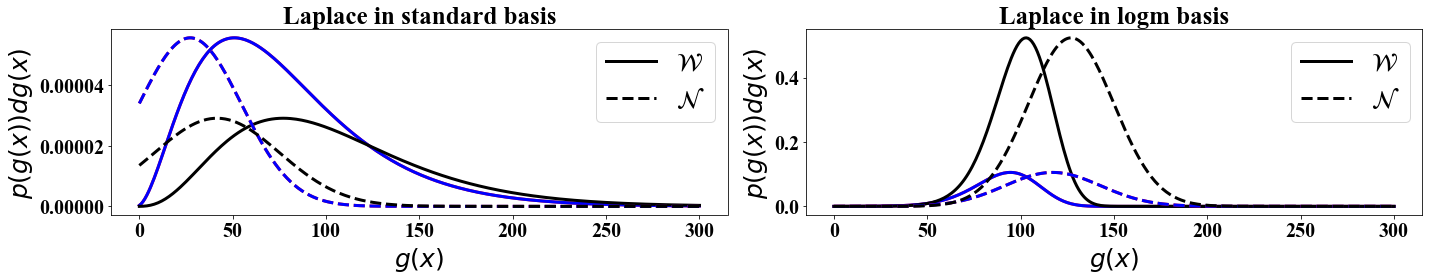

-0.5
(301, 2, 2)


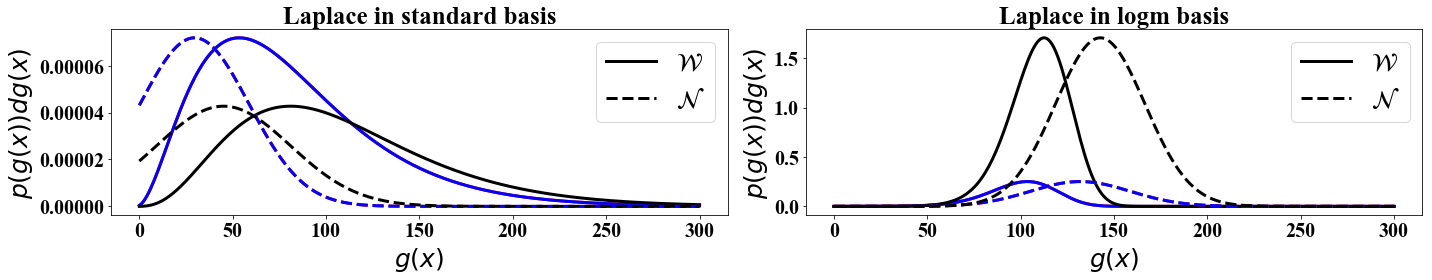

-0.4
(301, 2, 2)


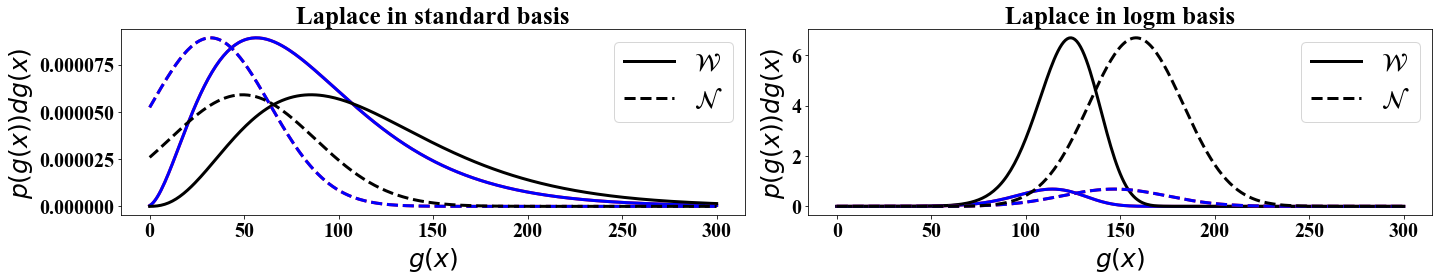

-0.29999999999999993
(301, 2, 2)


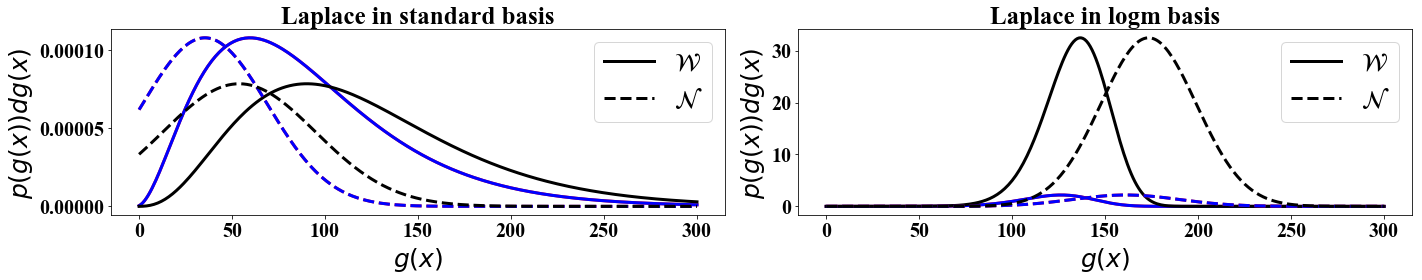

-0.19999999999999996
(301, 2, 2)


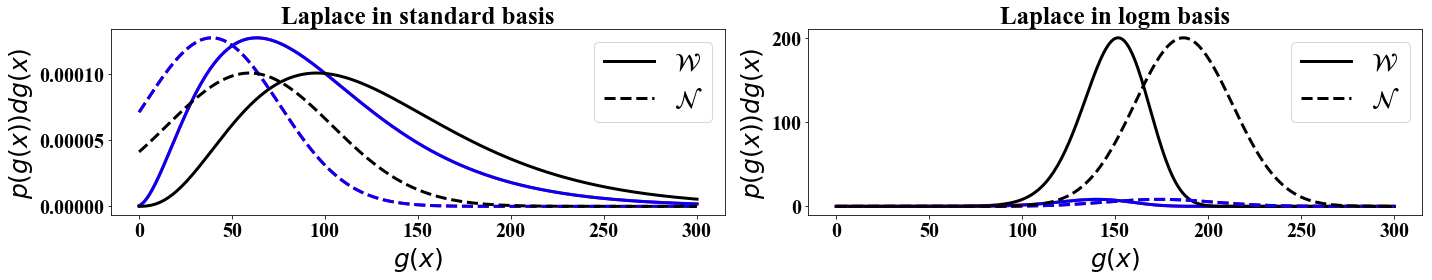

-0.09999999999999998
(301, 2, 2)


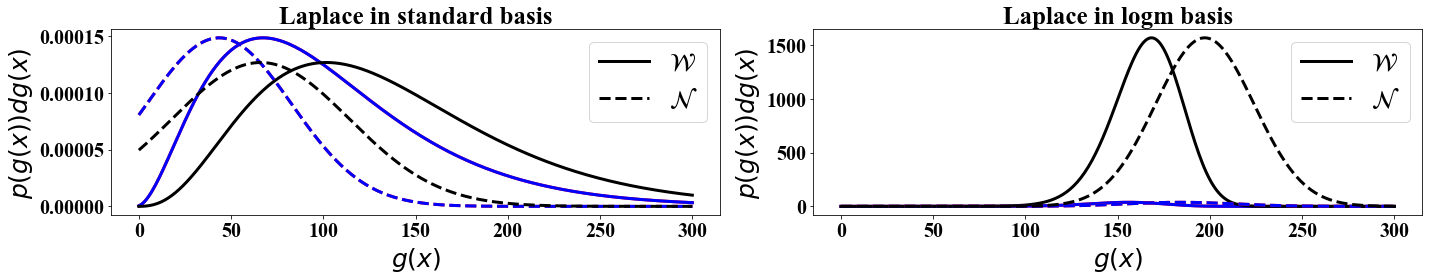

0.0
(301, 2, 2)


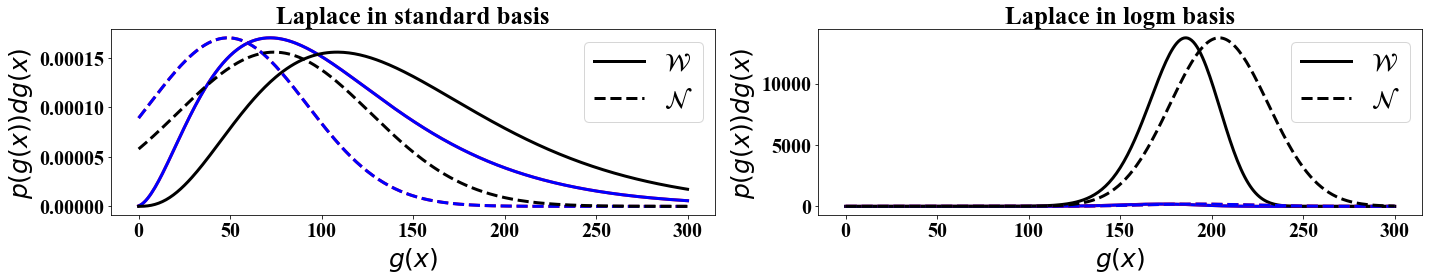

0.09999999999999998
(301, 2, 2)


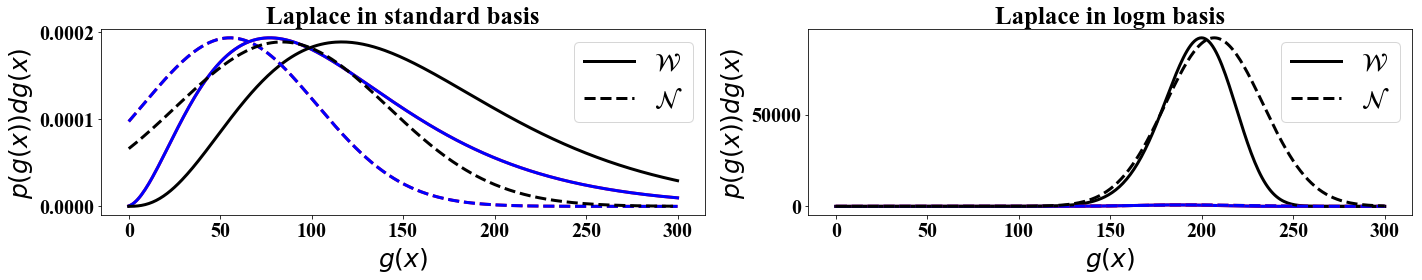

0.20000000000000007
(301, 2, 2)


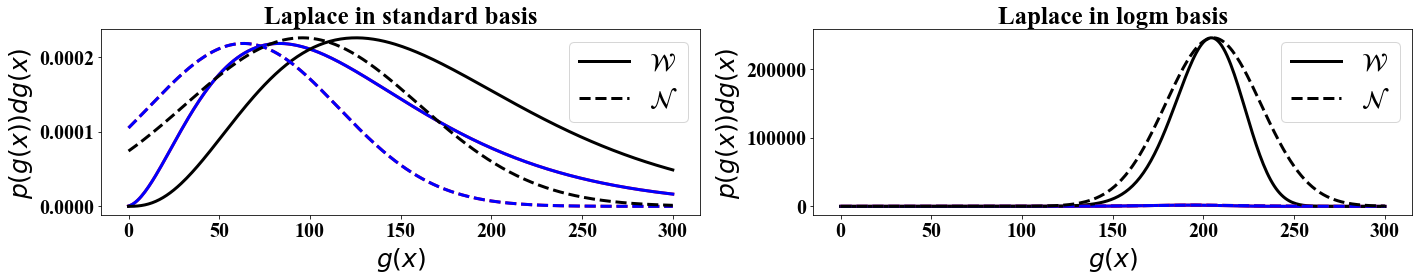

0.30000000000000016
(301, 2, 2)


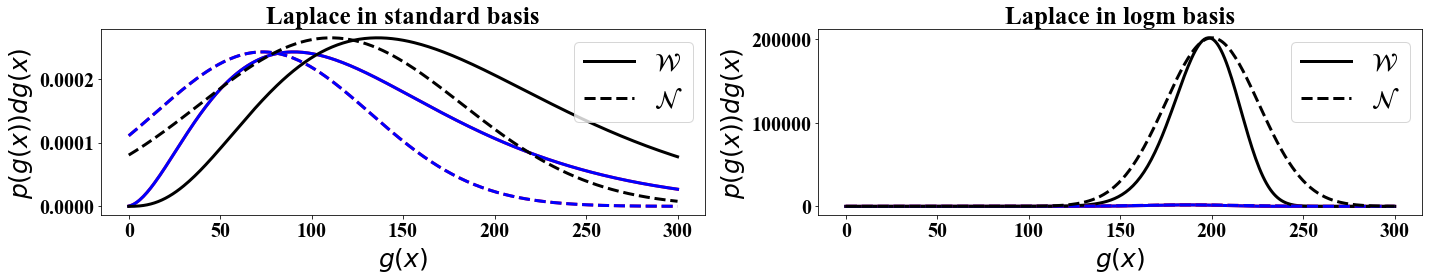

0.4
(301, 2, 2)


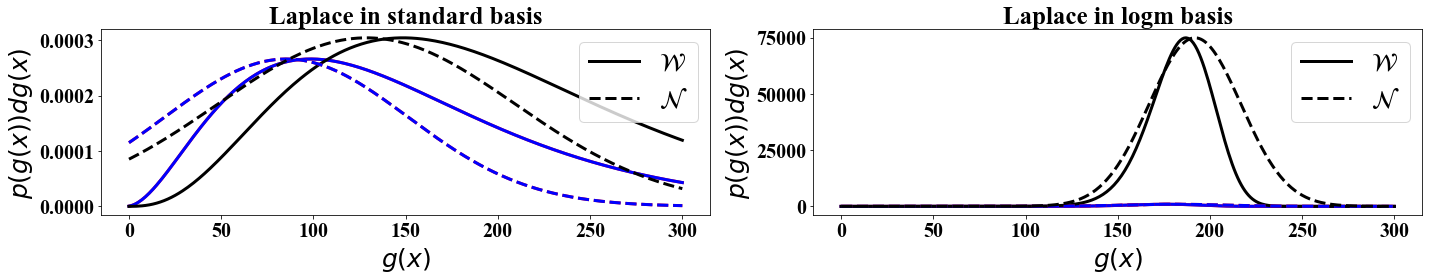

0.5000000000000001
(301, 2, 2)


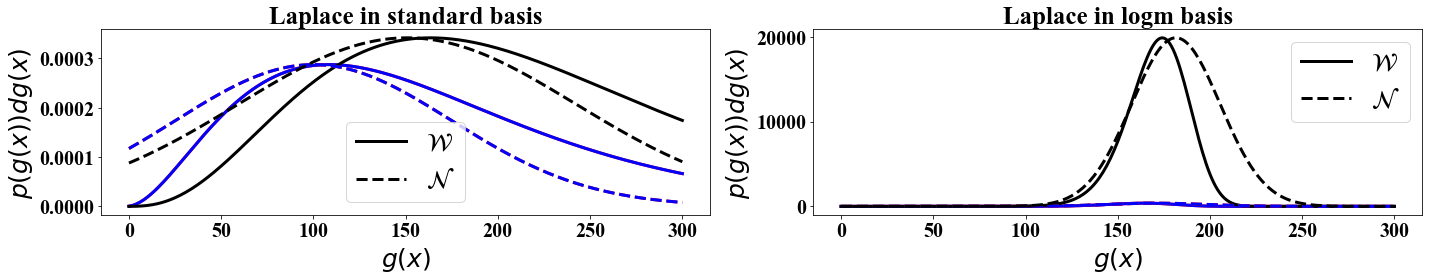

0.6
(301, 2, 2)


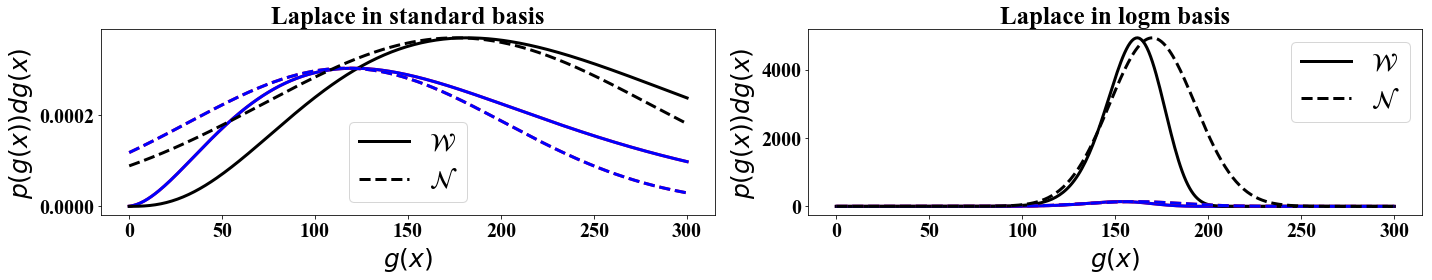

0.7000000000000001
(301, 2, 2)


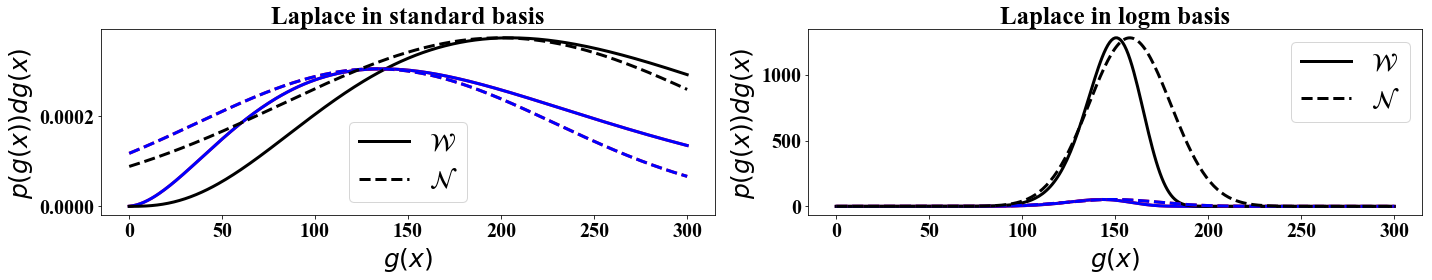

0.8000000000000002
(301, 2, 2)


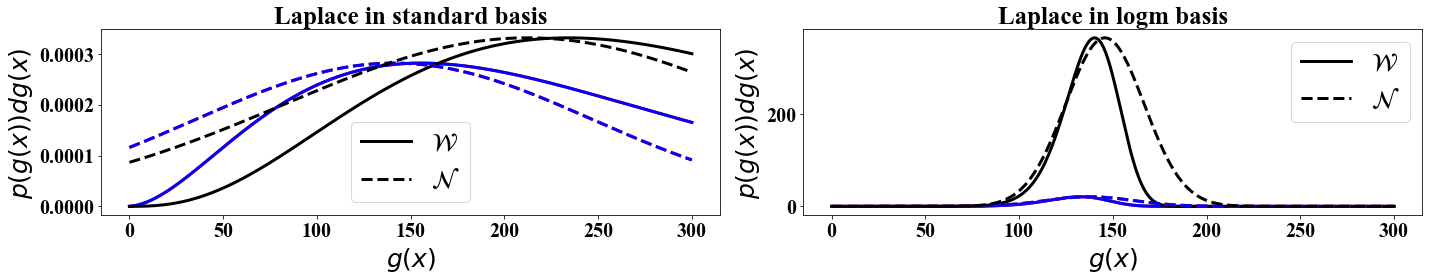

0.9
(301, 2, 2)


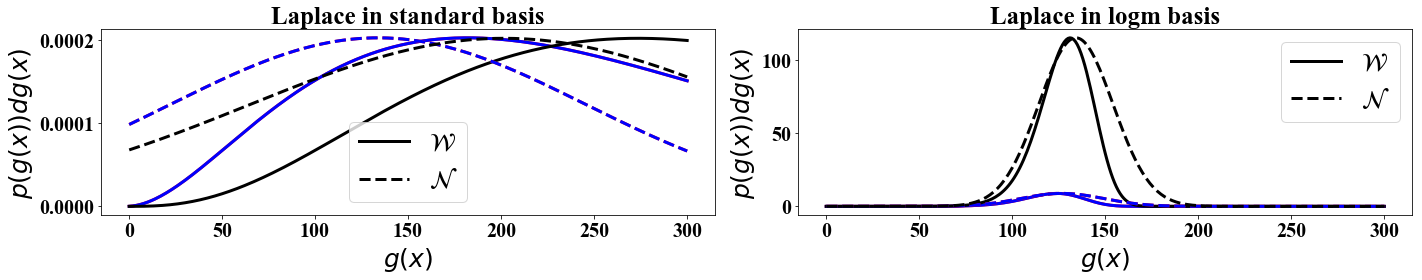

In [15]:
# test the function for multiple values of rho and s

""" values """

#s = np.eye(2)*2

#s = np.array([[4,2],
#             [2,3]])

s = np.array([[5,3],
             [3,4]])

is_pos_def(s)

n1 = 5
n2 = 5
n3 = 6

p=2

rhos = np.linspace(-0.9, 0.9, 19)

for r in rhos:
    
    print(r)
    xx = make_2D_psd_cone_cut(a_11, a_22, r)
    xxt = make_2D_psd_cone_cut(a_11_t, a_22_t, r)
    plot_Wishart_bridge_logm(xx=xx, xxt=xxt, ns=[n1,n2,n3], s=s, p=2, save=False, 
                             filename='delete.pdf', show_back=False)

# Verify the Bridge

In [16]:
n_test = 5
p_test = 2
s_test = np.array([[4,2],
                   [2,3]])

is_pos_def(s_test)

def wishart_t_logm_mode(n, p, V):
    return(logm((n-p+1) * V))

def wishart_t_logm_Sigma(n, p, V):
    return(2/(n-p+1) * np.eye(p**2))

def wishart_t_logm_V_from_mS(mu, Sigma, p, n):
    mu_ = mu.reshape(p,p)
    return(expm(mu_)/(n-p+1))

def wishart_t_logm_n_from_mS(mu, Sigma, p, V):
    mu_ = mu.reshape(p,p)
    return(expm(mu)@np.linalg.inv(V) + (p-1)*np.eye(p))

def wishart_t_logm_n_from_mS2(mu, Sigma, p):
    S_inv = np.linalg.inv(Sigma)
    print("S_inv: ", S_inv)
    return(2*S_inv + (p-1)*np.eye(p**2))

m_test = wishart_t_logm_mode(n_test, p_test, s_test)
S_test = wishart_t_logm_Sigma(n_test, p_test, s_test)
V_test = wishart_t_logm_V_from_mS(m_test, S_test, p_test, n_test)
print("m_test: ", m_test)
print("S_test: ", S_test)

n2_test = wishart_t_logm_n_from_mS(m_test, S_test, p_test, V_test)
n3_test = wishart_t_logm_n_from_mS2(m_test, S_test, p_test)

print(V_test)
print(n2_test)
print(n3_test)

m_test:  [[2.59000719 0.65596824]
 [0.65596824 2.26202307]]
S_test:  [[0.5 0.  0.  0. ]
 [0.  0.5 0.  0. ]
 [0.  0.  0.5 0. ]
 [0.  0.  0.  0.5]]
S_inv:  [[2. 0. 0. 0.]
 [0. 2. 0. 0.]
 [0. 0. 2. 0.]
 [0. 0. 0. 2.]]
[[4. 2.]
 [2. 3.]]
[[5. 0.]
 [0. 5.]]
[[5. 0. 0. 0.]
 [0. 5. 0. 0.]
 [0. 0. 5. 0.]
 [0. 0. 0. 5.]]


In [17]:
import scipy
X_test = create_spd_matrix(p=4)
X_test = 1/2 * X_test + X_test.T
m_ = np.random.random((4))
n2_test_matrix = wishart_t_logm_n_from_mS2(m_, X_test, p=2)
V2_test = wishart_t_logm_V_from_mS(m_, X_test, 2, n2_test)
print("X_test: ", X_test)
print("V2_test: ", V2_test)
print("m_: ", m_)
print("n2_test: ", n2_test_matrix)
U, sing, V = scipy.linalg.svd(n2_test_matrix)
print("singular values: ", sing)
print("U: ", U)
print("V: ", V)
r1_approx = sing[0] * np.outer(U[0], V[0])
#print("rank-1 approx: ", r1_approx)
#print("rank-1 diagonal: ", r1_approx.diagonal())

eigs = np.linalg.eigvals(n2_test_matrix)
print("eigs: ", eigs)
n2_test_val = np.sqrt(np.sum(sing**2) - sing[0]**2- sing[1]**2)
n2_test_val_1 = np.sum(sing**2) - sing[0]**2
#n2_test_val = eigs.mean()
#n2_test_val = n2_test_matrix.diagonal().min()

m2_test = wishart_t_logm_mode(n2_test_val, 2, V2_test)
S2_test = wishart_t_logm_Sigma(n2_test_val, 2, V2_test)
m2_test_1 = wishart_t_logm_mode(n_test, 2, V2_test)
S2_test_1 = wishart_t_logm_Sigma(n2_test_val_1, 2, V2_test)

print("m': ", m2_test)
print("X': ", S2_test)
print("m2': ", m2_test_1)
print("X2': ", S2_test_1)


X_spd is spd:  True
S_inv:  [[ 41.578644  -17.872673  -26.255531    3.739309 ]
 [-17.872673    8.970681   10.873405   -2.4480474]
 [-26.255531   10.873405   18.04929    -3.0307395]
 [  3.739309   -2.4480474  -3.0307395   2.539139 ]]
X_test:  [[1.1458302  1.1618801  1.0900713  0.7338893 ]
 [1.1618801  1.6266816  0.858218   0.88163745]
 [1.0900713  0.858218   1.242473   0.70514333]
 [0.7338893  0.88163745 0.70514333 1.0047332 ]]
V2_test:  [[ 0.28153643 -0.57645255]
 [-0.20693327  0.3287654 ]]
m_:  [0.07462544 0.48656082 0.1746642  0.23408187]
n2_test:  [[ 84.1572876  -35.74534607 -52.51106262   7.47861814]
 [-35.74534607  18.94136238  21.74681091  -4.8960948 ]
 [-52.51106262  21.74681091  37.09857941  -6.06147909]
 [  7.47861814  -4.8960948   -6.06147909   6.07827806]]
singular values:  [134.33502213   6.00237517   4.44105515   1.497055  ]
U:  [[-0.78673524 -0.26751004 -0.19973982  0.51922061]
 [ 0.34271105 -0.37248552  0.64302283  0.57473935]
 [ 0.50667928 -0.01805567 -0.71317563  0.484

# Visualization

we follow the 4-layer visualization approach by Gelman (http://www.stat.columbia.edu/~gelman/research/unpublished/Visualization.pdf)

In [18]:
from scipy.stats import wishart

In [19]:
s = np.array([[4,2],
             [2,3]])

n1 = 5

num_samples=25000

wishart_samples = wishart.rvs(df=n1, scale=s, size=num_samples, random_state=None)
wishart_samples_1000 = wishart.rvs(df=n1, scale=s, size=1000, random_state=None)

In [20]:
print(np.shape(wishart_samples))
print(wishart_samples[0])

(25000, 2, 2)
[[16.10934547  6.6692408 ]
 [ 6.6692408   5.5104114 ]]


In [21]:
sigma_00 = np.sqrt(wishart_samples[:,0,0])
sigma_11 = np.sqrt(wishart_samples[:,1,1])
sigma_01 = wishart_samples[:,0,1]
rho_01 = sigma_01/(sigma_00 * sigma_11)

In [22]:
def plot_histograms(samples_2D, sqrt=True):
    
    #get values
    samples_flat = samples_2D.reshape(len(samples_2D), -1)
    if sqrt:
        sigma_00 = np.sqrt(samples_flat[:,0]) 
    else:
        sigma_00 = samples_flat[:,0]
    sigma_01 = samples_flat[:,1]
    sigma_10 = samples_flat[:,2]
    if sqrt:
        sigma_11 = np.sqrt(samples_flat[:,3])
    else:
        sigma_11 = samples_flat[:,3]
    rho_01 = sigma_01/(sigma_00 * sigma_11)  
    rho_10 = sigma_10/(sigma_00 * sigma_11)  
    
    #plot values
    fig, axs = plt.subplots(nrows=3, ncols=2, sharex=False, figsize=(12, 17))
    axs[0][0].hist(sigma_00, bins=100)
    axs[0][0].set_title("sigma_00")
    axs[0][1].hist(sigma_01, bins=100)
    axs[0][1].set_title("sigma_01")
    axs[1][0].hist(sigma_10, bins=100)
    axs[1][0].set_title("sigma_10")
    axs[1][1].hist(sigma_11, bins=100)
    axs[1][1].set_title("sigma_11")
    axs[2][0].hist(rho_01, bins=100)
    axs[2][0].set_title("rho_01")
    axs[2][1].hist(rho_10, bins=100)
    axs[2][1].set_title("rho_10")
    
    plt.show()

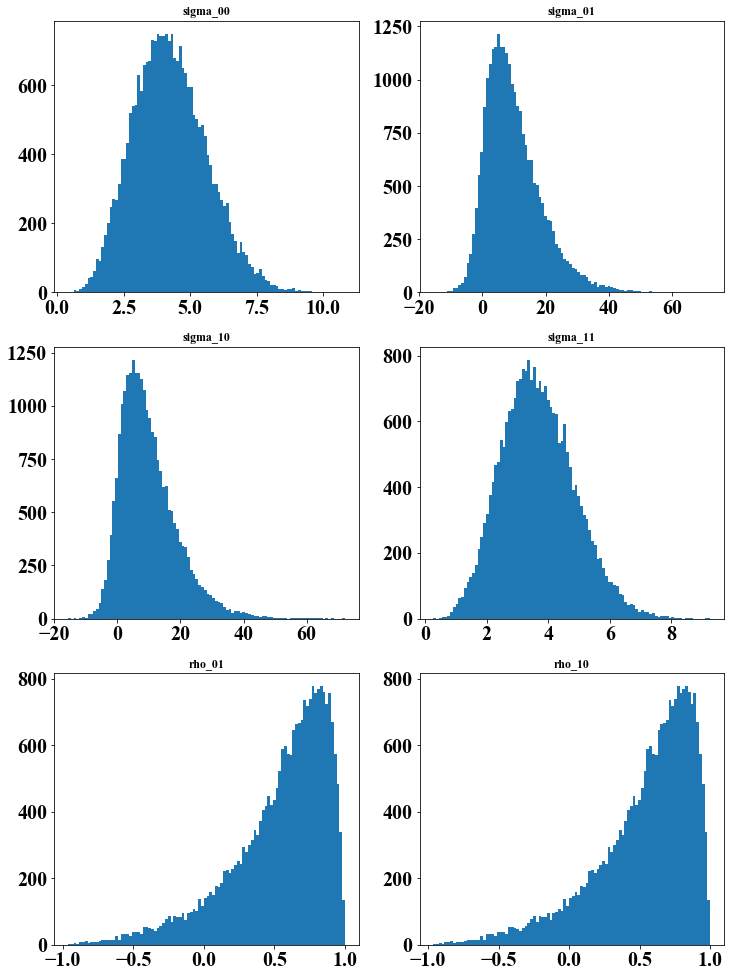

In [23]:
plot_histograms(wishart_samples, sqrt=True)

In [24]:
wishart_samples_sqrtm = np.array([sqrtm(x) for x in wishart_samples])
wishart_samples_1000_sqrtm = np.array([sqrtm(x) for x in wishart_samples_1000])
print(np.shape(wishart_samples_sqrtm))
print(wishart_samples_sqrtm[0])

(25000, 2, 2)
[[3.85174961 1.12843716]
 [1.12843716 2.05840739]]


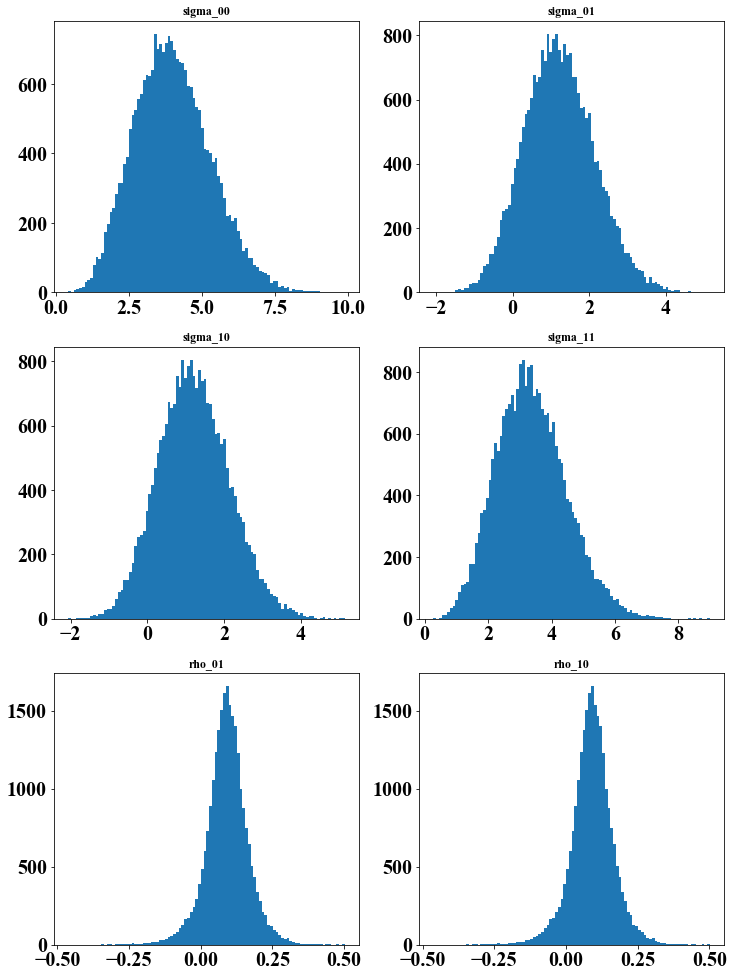

In [25]:
plot_histograms(wishart_samples_sqrtm, sqrt=False)

In [26]:
wishart_samples_logm = np.array([logm(x) for x in wishart_samples])
print(np.shape(wishart_samples_logm))
print(wishart_samples_logm[0])

(25000, 2, 2)
[[2.55867897 0.83474015]
 [0.83474015 1.23208781]]


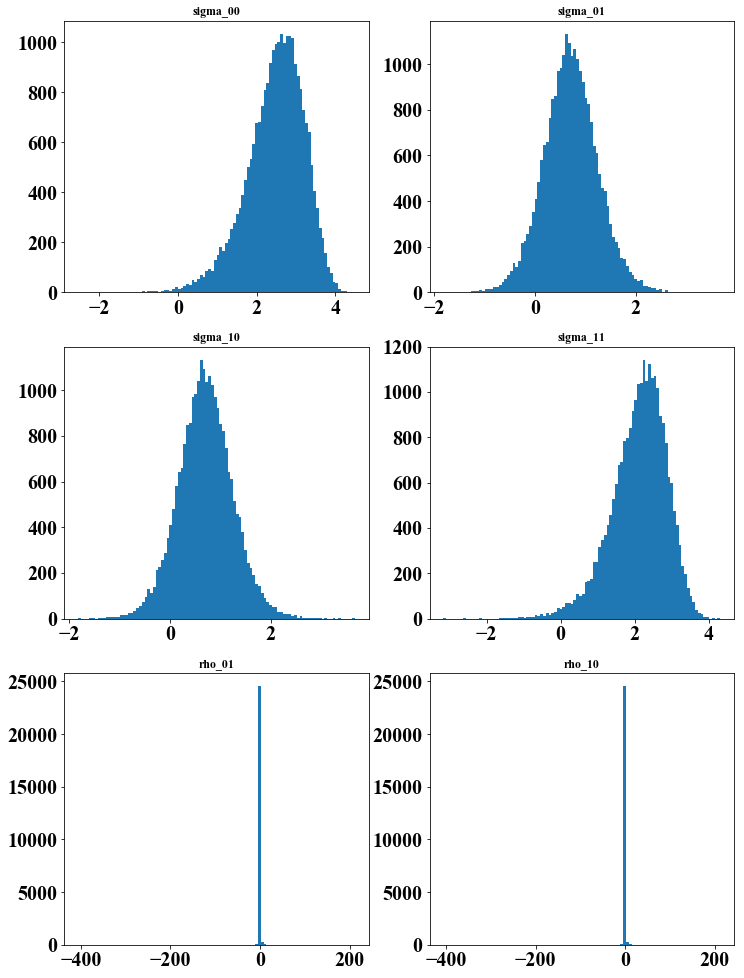

In [27]:
plot_histograms(wishart_samples_logm, sqrt=False)

In [28]:
mode1 = wishart_mode(n1, p=2, V=s).reshape(-1)
print("mode1: ", mode1)

Sigma1 = wishart_Sigma(n1, p=2, V=s)
print("sigma1: ", Sigma1)
    
is_pos_def(Sigma1)

mode1:  [8 4 4 6]
sigma1:  [[64. 32. 32. 16.]
 [32. 48. 16. 24.]
 [32. 16. 48. 24.]
 [16. 24. 24. 36.]]


True

In [29]:
def plot_histograms_compare(samples_Wishart, samples_Gaussian, sqrt=True):
    
    #get values for the Wishart
    samples_flat = samples_Wishart.reshape(len(samples_Wishart), -1)
    if sqrt:
        sigma_00 = np.sqrt(samples_flat[:,0]) 
    else:
        sigma_00 = samples_flat[:,0]
    sigma_01 = samples_flat[:,1]
    sigma_10 = samples_flat[:,2]
    if sqrt:
        sigma_11 = np.sqrt(samples_flat[:,3])
    else:
        sigma_11 = samples_flat[:,3]
    rho_01 = sigma_01/(sigma_00 * sigma_11)  
    rho_10 = sigma_10/(sigma_00 * sigma_11) 
    
    #get values for the Gaussian
    samples_G = samples_Gaussian.reshape(len(samples_Gaussian), -1)
    if sqrt:
        sigma_G_00 = np.sqrt(samples_G[:,0]) 
    else:
        sigma_G_00 = samples_G[:,0]
    sigma_G_01 = samples_G[:,1]
    sigma_G_10 = samples_G[:,2]
    if sqrt:
        sigma_G_11 = np.sqrt(samples_G[:,3])
    else:
        sigma_G_11 = samples_G[:,3]
    rho_G_01 = sigma_G_01/(sigma_G_00 * sigma_G_11)  
    rho_G_10 = sigma_G_10/(sigma_G_00 * sigma_G_11) 
    
    #plot values
    a = 0.5
    fig, axs = plt.subplots(nrows=3, ncols=2, sharex=False, figsize=(12, 17))
    axs[0][0].hist(sigma_00, bins=100, alpha=a)
    axs[0][0].hist(sigma_G_00, bins=100, alpha=a)
    axs[0][0].set_title("sigma_00")
    axs[0][1].hist(sigma_01, bins=100, alpha=a)
    axs[0][1].hist(sigma_G_01, bins=100, alpha=a)
    axs[0][1].set_title("sigma_01")
    axs[1][0].hist(sigma_10, bins=100, alpha=a)
    axs[1][0].hist(sigma_G_10, bins=100, alpha=a)
    axs[1][0].set_title("sigma_10")
    axs[1][1].hist(sigma_11, bins=100, alpha=a)
    axs[1][1].hist(sigma_G_11, bins=100, alpha=a)
    axs[1][1].set_title("sigma_11")
    axs[2][0].hist(rho_01, bins=100, alpha=a)
    axs[2][0].hist(rho_G_01, bins=100, alpha=a)
    axs[2][0].set_title("rho_01")
    axs[2][1].hist(rho_10, bins=100, alpha=a)
    axs[2][1].hist(rho_G_10, bins=100, alpha=a)
    axs[2][1].set_title("rho_10")
    
    plt.show()

In [30]:
from scipy.stats import multivariate_normal as mv_norm

mv_norm_samples = mv_norm.rvs(mean=mode1, cov=Sigma1, size=num_samples)

In [31]:
print(np.shape(mv_norm_samples))
print(mv_norm_samples[0])

(25000, 4)
[ 1.00851607 -5.58289212  1.87499911  8.02548987]


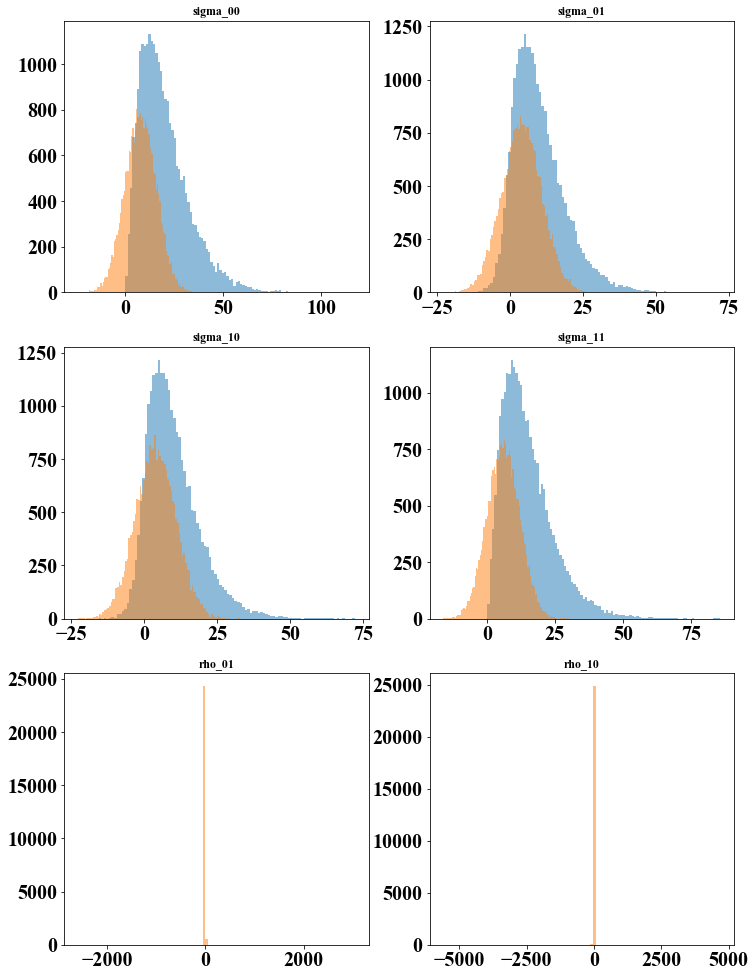

In [32]:
plot_histograms_compare(wishart_samples, mv_norm_samples, sqrt=False)

In [33]:
mode1_sqrtm = wishart_t_sqrtm_mode(n1, p=2, V=s)
print("mode1: ", mode1_sqrtm)

Sigma1_sqrtm = wishart_t_sqrtm_Sigma(n1, p=2, V=s)
print("sigma1: ", Sigma1_sqrtm)
    
is_pos_def(Sigma1_sqrtm)
mode1_sqrtm = mode1_sqrtm.reshape(-1)

mv_norm_samples_sqrtm = mv_norm.rvs(mean=mode1_sqrtm, cov=Sigma1_sqrtm, size=num_samples)

mode1:  [[3.32443937 0.97370575]
 [0.97370575 2.8375865 ]]
sigma1:  [[1.84198285 0.76297428 0.31603429 0.15801715]
 [0.76297428 1.46049571 0.15801715 0.23702572]
 [0.31603429 0.15801715 1.68396571 0.68396571]
 [0.15801715 0.23702572 0.68396571 1.34198285]]


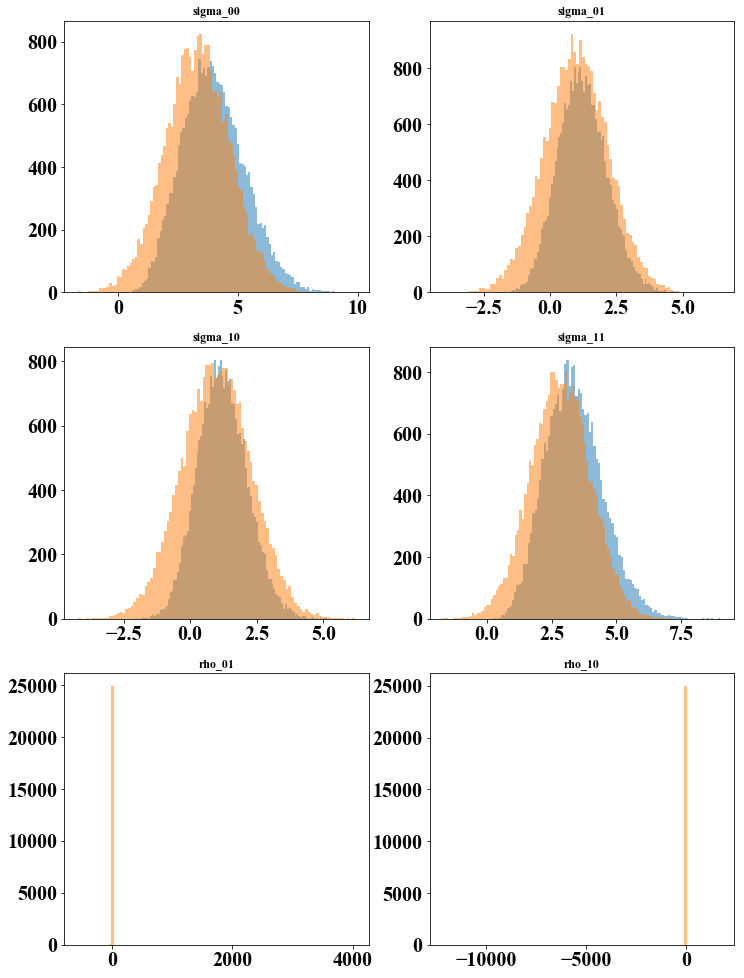

In [34]:
plot_histograms_compare(wishart_samples_sqrtm, mv_norm_samples_sqrtm, sqrt=False)

In [35]:
n1 = 5

s = np.array([[4,2],
             [2,3]])

mode1 = wishart_mode(n1, p=2, V=s).reshape(-1)
print("mode1: ", mode1)

Sigma1 = wishart_Sigma(n1, p=2, V=s)
print("sigma1: ", Sigma1)
    
is_pos_def(Sigma1)

mode1_sqrtm = wishart_t_sqrtm_mode(n1, p=2, V=s)
print("mode1: ", mode1_sqrtm)

Sigma1_sqrtm = wishart_t_sqrtm_Sigma(n1, p=2, V=s)
print("sigma1: ", Sigma1_sqrtm)
    
is_pos_def(Sigma1_sqrtm)
mode1_sqrtm = mode1_sqrtm.reshape(-1)

wishart_samples_1000 = wishart.rvs(df=n1, scale=s, size=1000, random_state=None)
wishart_samples_1000_logm = np.array([logm(x) for x in wishart_samples_1000])
wishart_samples_1000_sqrtm = np.array([sqrtm(x) for x in wishart_samples_1000])
mv_norm_samples_1000 = mv_norm.rvs(mean=mode1, cov=Sigma1, size=1000)
mv_norm_samples_1000_sqrtm = mv_norm.rvs(mean=mode1_sqrtm, cov=Sigma1_sqrtm, size=1000)

mode1:  [8 4 4 6]
sigma1:  [[64. 32. 32. 16.]
 [32. 48. 16. 24.]
 [32. 16. 48. 24.]
 [16. 24. 24. 36.]]
mode1:  [[3.32443937 0.97370575]
 [0.97370575 2.8375865 ]]
sigma1:  [[1.84198285 0.76297428 0.31603429 0.15801715]
 [0.76297428 1.46049571 0.15801715 0.23702572]
 [0.31603429 0.15801715 1.68396571 0.68396571]
 [0.15801715 0.23702572 0.68396571 1.34198285]]


## other way to visualize 4D matrices

In [36]:
import plotly
import plotly.graph_objs as go


def plot_samples_4D(samples):
    
    #reshape
    data = samples.reshape((len(samples), -1))

    #Set marker properties
    markercolor = data[:,2]

    #Make Plotly figure
    fig1 = go.Scatter3d(x=data[:,0],
                        y=data[:,1],
                        z=data[:,3],
                        marker=dict(color=markercolor,
                                    opacity=1,
                                    reversescale=True,
                                    colorscale='Blues',
                                    size=5),
                        line=dict (width=0.02),
                        mode='markers')

    #Make Plot.ly Layout
    mylayout = go.Layout(scene=dict(xaxis=dict( title="sigma_00"),
                                    yaxis=dict( title="sigma_01"), 
                                    zaxis=dict(title="sigma_11")))

    #Plot and save html
    plotly.offline.plot({"data": [fig1],
                         "layout": mylayout},
                         auto_open=True,
                         filename=("4DPlot.html"))

In [37]:
plot_samples_4D(wishart_samples_1000)

In [38]:
plot_samples_4D(mv_norm_samples_1000)

In [39]:
plot_samples_4D(wishart_samples_1000_sqrtm)

In [40]:
plot_samples_4D(mv_norm_samples_1000_sqrtm)

# Statistical distance measures

In [41]:
from torch_two_sample import MMDStatistic
from scipy.stats import wishart
from scipy.stats import multivariate_normal as mv_norm
import torch

## starting with MMD for 25 pairs of parameters

In [42]:
def MMD_combinations(params, plot=False, n_samples=1000, verbose=True):
    
    Ns = params[0]
    Vs = params[1]
    p = np.shape(Vs[0])[0]
    
    MMD_sum = 0
    MMD_t_logm_sum = 0 
    MMD_t_sqrtm_sum = 0 

    for n in Ns:
        for v in Vs:
            
            if verbose:
                print("n: ", n, "V: ", v)

            if n <= p + 1:
                print("n <= p+1 doesn't yield a Laplace Approximation in standard basis")

            #get samples from all dists
            #standard
            W_samples = wishart.rvs(n, v, size=n_samples)
            if n > p+1:         
                mode1 = wishart_mode(n, p, v).reshape(-1)
                Sigma1 = wishart_Sigma(n, p, v)
                N_samples = mv_norm.rvs(mode1, Sigma1, size=n_samples)

            #logm
            mode1_logm = wishart_t_logm_mode(n, p, v).reshape(-1)
            Sigma1_logm = wishart_t_logm_Sigma(n, p, v)
            W_samples_logm = np.array([logm(w) for w in W_samples])
            N_samples_logm = mv_norm.rvs(mode1_logm, Sigma1_logm, size=n_samples)
            
            
            #sqrtm
            mode1_sqrtm = wishart_t_sqrtm_mode(n, p, v).reshape(-1)
            Sigma1_sqrtm = wishart_t_sqrtm_Sigma(n, p, v)
            W_samples_sqrtm = np.array([sqrtm(w) for w in W_samples])
            N_samples_sqrtm = mv_norm.rvs(mode1_sqrtm, Sigma1_sqrtm, size=n_samples)


            #calculate MMD for all bases
            MMD = MMDStatistic(n_samples, n_samples)

            #standard
            W_samples_ = torch.Tensor(W_samples.reshape((n_samples, -1)))
            if n > p+1:         
                N_samples_ = torch.Tensor(N_samples.reshape((n_samples, -1)))
                MMD_ = MMD(W_samples_, N_samples_,  alphas=[0.5], ret_matrix=False)
                MMD_ = torch.max(torch.zeros(1), MMD_)
            else:
                MMD_ = torch.Tensor([np.nan])

            #logm
            W_samples_logm_ = torch.Tensor(W_samples_logm.reshape((n_samples, -1)))
            N_samples_logm_ = torch.Tensor(N_samples_logm.reshape((n_samples, -1)))
            MMD_logm_= MMD(W_samples_logm_, N_samples_logm_,  alphas=[0.5], ret_matrix=False)
            MMD_logm_= torch.max(torch.zeros(1), MMD_logm_)
            
            #sqrtm
            W_samples_sqrtm_ = torch.Tensor(W_samples_sqrtm.reshape((n_samples, -1)))
            N_samples_sqrtm_ = torch.Tensor(N_samples_sqrtm.reshape((n_samples, -1)))
            MMD_sqrtm_= MMD(W_samples_sqrtm_, N_samples_sqrtm_,  alphas=[0.5], ret_matrix=False)
            MMD_sqrtm_= torch.max(torch.zeros(1), MMD_sqrtm_)

            if plot:
                rhos = np.linspace(-0.9, 0.9, 19)
                
                print("Logm base")
                for r in rhos:
                    
                    print(r)
                    xx = make_2D_psd_cone_cut(a_11, a_22, r)
                    plot_Wishart_bridge_logm(xx=xx, ns=[n, n, n], s=v, p=2, save=False, filename='')

                print("Sqrtm base")
                for r in rhos:
                    
                    print(r)
                    xx = make_2D_psd_cone_cut(a_11, a_22, r)
                    plot_Wishart_bridge_sqrtm(xx=xx, ns=[n, n, n], s=v, p=2, save=False, filename='')

            if verbose: 
                print("standard: ", MMD_.item(), "logm: ", MMD_logm_.item(), "sqrtm: ", MMD_sqrtm_.item())

            #add them to their respective sums
            MMD_sum += MMD_
            MMD_t_logm_sum += MMD_logm_
            MMD_t_sqrtm_sum += MMD_sqrtm_

    return(MMD_sum.item(), MMD_t_logm_sum.item(), MMD_t_sqrtm_sum.item())

In [43]:
np.random.seed(42)
random_Vs = [create_spd_matrix(p=3, eps=10e-3) for _ in range(5)]
MMD_combinations(params=[range(4,9), random_Vs], plot=False, verbose=True, n_samples=2000)

X_spd is spd:  True
X_spd is spd:  True
X_spd is spd:  True
X_spd is spd:  True
X_spd is spd:  True
n:  4 V:  [[0.7196955  0.40080962 0.5044944 ]
 [0.40080962 0.819459   0.7261089 ]
 [0.5044944  0.7261089  0.70244265]]
n <= p+1 doesn't yield a Laplace Approximation in standard basis
logm result may be inaccurate, approximate err = 3.8495942977617194e-07


/home/marius/anaconda3/lib/python3.7/site-packages/scipy/stats/_multivariate.py:660: RuntimeWarning:

covariance is not positive-semidefinite.



standard:  nan logm:  0.06926871091127396 sqrtm:  0.18579889833927155
n:  4 V:  [[1.0319746  0.8747895  0.6337034 ]
 [0.8747895  0.80689573 0.7350414 ]
 [0.6337034  0.7350414  1.1742783 ]]
n <= p+1 doesn't yield a Laplace Approximation in standard basis
logm result may be inaccurate, approximate err = 2.9456594186254674e-07
standard:  nan logm:  0.07022052258253098 sqrtm:  0.1584337055683136
n:  4 V:  [[0.90334845 0.38403755 0.5131475 ]
 [0.38403755 0.18321072 0.28229433]
 [0.5131475  0.28229433 0.77366835]]
n <= p+1 doesn't yield a Laplace Approximation in standard basis
logm result may be inaccurate, approximate err = 1.3071304696952116e-07
standard:  nan logm:  0.0652550533413887 sqrtm:  0.18557095527648926
n:  4 V:  [[0.5751168  0.49886215 0.6915537 ]
 [0.49886215 0.9726566  0.1702734 ]
 [0.6915537  0.1702734  1.2273012 ]]
n <= p+1 doesn't yield a Laplace Approximation in standard basis
logm result may be inaccurate, approximate err = 1.269744126335281e-06
standard:  nan logm:  0.0

(nan, 2.082712173461914, 2.8121140003204346)

In [44]:
results_MMD = np.array([5.249842643737793, 2.105339765548706, 3.1880857944488525])
results_MMD_normed = results_MMD/results_MMD[0]
print(results_MMD_normed)

[1.         0.40102912 0.60727264]


## KL-divergence (mode seeking/backward, from samples)

In [45]:
# check out Samples vs Dir
# True distributions belong to samples_1
# Laplace approximations belong to samples_2

def KL_divergence_samples(samples_1, samples_2, plot=False):
    
    assert(len(samples_1) == len(samples_2))
    n_bins = 10000 #int(np.sqrt(np.sqrt(len(samples_1))))
    
    if not isinstance(samples_1, np.ndarray):
        samples_1 = samples_1.numpy()
        samples_2 = samples_2.numpy()
    
    #make histograms
    hist1, _ = np.histogramdd(samples_1, density=True, bins=[10, 10, 10, 10])
    hist2, _ = np.histogramdd(samples_2, density=True, bins=[10, 10, 10, 10])

    
    #don't divide by 0
    hist1 += 1e-8
    hist2 += 1e-8
    
    #calculate KL_div
    KL_div = (hist1 * np.log(hist1 / hist2))
    #KL_div = (hist2 * np.log(hist2 / hist1))

    if plot:
        print("plotting 1D marginal of the Wishart which is a Chi-squared")
        plt.plot(hist1[4,:,4, 4], label='hist1')
        plt.plot(hist2[4,:,4, 4], label='hist2')
        plt.plot(KL_div[4,:,4, 4], lw=1, label='KL_div')
        plt.legend()
        plt.show()
            
    KL_div = np.sum(np.abs(KL_div))/n_bins
    
    #normalize for fair comparison
    KL_div /= np.max(hist1)
        
    return(KL_div)

# Statistical distance measures for small, medium and large $\theta$

In [46]:
np.random.seed(42)

p_ = 2

n_s, v_s = p_ + 0, create_spd_matrix(p=p_, eps=10e-3)
n_m, v_m = p_ + 2, create_spd_matrix(p=p_, eps=10e-3) 
n_l, v_l = p_ + 10, create_spd_matrix(p=p_, eps=10e-3)

X_spd is spd:  True
X_spd is spd:  True
X_spd is spd:  True


## calculate MMD for the three pairs of parameters

In [47]:
# use 10 seeds
MMD_results_s = []
MMD_results_m = []
MMD_results_l = []

for s in range(10):
    print("seed: ", s)
    np.random.seed(s)
    torch.manual_seed(s)
    MMD_s = MMD_combinations(params = [[n_s], [v_s]], n_samples=2000, plot=False)
    MMD_m = MMD_combinations(params = [[n_m], [v_m]], n_samples=2000, plot=False)
    MMD_l = MMD_combinations(params = [[n_l], [v_l]], n_samples=2000)
    MMD_results_s += [MMD_s]
    MMD_results_m += [MMD_m]
    MMD_results_l += [MMD_l]
    
MMD_results_mean_s = np.array(MMD_results_s).mean(0)
MMD_results_mean_m = np.array(MMD_results_m).mean(0)
MMD_results_mean_l = np.array(MMD_results_l).mean(0)
print(MMD_results_mean_s)
print(MMD_results_mean_m)
print(MMD_results_mean_l)

seed:  0
n:  2 V:  [[0.7417887  0.60732496]
 [0.60732496 0.5140302 ]]
n <= p+1 doesn't yield a Laplace Approximation in standard basis
logm result may be inaccurate, approximate err = 7.348781503667318e-08
standard:  nan logm:  0.06484459340572357 sqrtm:  0.4559398293495178
n:  4 V:  [[0.7163863  0.83832943]
 [0.83832943 1.0049176 ]]
logm result may be inaccurate, approximate err = 1.895866298881657e-07
standard:  0.1304037868976593 logm:  0.07112817466259003 sqrtm:  0.07341581583023071
n:  12 V:  [[0.21941449 0.20016307]
 [0.20016307 0.24439938]]
logm result may be inaccurate, approximate err = 8.19835091186812e-08
standard:  0.029444396495819092 logm:  0.01556384563446045 sqrtm:  0.012460529804229736
seed:  1
n:  2 V:  [[0.7417887  0.60732496]
 [0.60732496 0.5140302 ]]
n <= p+1 doesn't yield a Laplace Approximation in standard basis
logm result may be inaccurate, approximate err = 7.348781503667318e-08
standard:  nan logm:  0.06414835155010223 sqrtm:  0.4370163083076477
n:  4 V:  [[0

In [48]:
# normalize to 1 for comparison
MMD_results_mean_s[0] = MMD_results_mean_s[1:].max()
MMD_results_mean_s_normalized = MMD_results_mean_s/MMD_results_mean_s.max()
MMD_results_mean_s_normalized[0] = np.nan
print(MMD_results_mean_s_normalized)
print(MMD_results_mean_m/MMD_results_mean_m.max())
print(MMD_results_mean_l/MMD_results_mean_l.max())

[       nan 0.14210159 1.        ]
[1.         0.58241368 0.51653669]
[1.         0.51584499 0.42614486]


## calculate KL div for the three pairs of parameters

In [49]:
def KL_combinations(params, n_samples=10000, verbose=True, plot=False):
    
    n = params[0]
    v = np.array(params[1])
    p = v[0].shape[0]

    if n <= p + 1:
        print("Wishart has no valid Laplace Approximation in standard base for n <= p+1")

    W_samples = np.array([x.reshape(-1) for x in wishart.rvs(n, v, size=n_samples)])
    if n > p + 1:
        mu = wishart_mode(n, p, v).reshape(-1)
        Sigma = wishart_Sigma(n, p, v)
        N_samples = mv_norm.rvs(mu, Sigma, size=n_samples)
    
    print(np.shape(W_samples))
    
    if n > p+1:
        KL_ = KL_divergence_samples(W_samples, N_samples, plot=plot)
    else:
        KL_ = torch.Tensor([np.nan])
    
    ####logm base
    mode1_logm = wishart_t_logm_mode(n, p, v).reshape(-1)
    Sigma1_logm = wishart_t_logm_Sigma(n, p, v)
    W_samples_logm = np.array([logm(w.reshape(p,p)).reshape(-1) for w in W_samples])
    N_samples_logm = mv_norm.rvs(mode1_logm, Sigma1_logm, size=n_samples)
    
    KL_logm_ = KL_divergence_samples(W_samples_logm, N_samples_logm, plot=plot)
    
    ####sqrtm base
    mode1_sqrtm = wishart_t_sqrtm_mode(n, p, v).reshape(-1)
    Sigma1_sqrtm = wishart_t_sqrtm_Sigma(n, p, v)
    W_samples_sqrtm = np.array([sqrtm(w.reshape(p,p)).reshape(-1) for w in W_samples])
    N_samples_sqrtm = mv_norm.rvs(mode1_sqrtm, Sigma1_sqrtm, size=n_samples)
    
    KL_sqrtm_ = KL_divergence_samples(W_samples_sqrtm, N_samples_sqrtm, plot=plot)
    
    """
    if plot:
        rhos = np.linspace(-0.9, 0.9, 19)

        print("Logm base")
        for r in rhos:

            print(r)
            xx = make_2D_psd_cone_cut(a_11, a_22, r)
            plot_Wishart_bridge_logm(xx=xx, ns=[n, n, n], s=v, p=2, save=False, filename='')

        print("Sqrtm base")
        for r in rhos:

            print(r)
            xx = make_2D_psd_cone_cut(a_11, a_22, r)
            plot_Wishart_bridge_sqrtm(xx=xx, ns=[n, n, n], s=v, p=2, save=False, filename='')      
    """
    
    if verbose: 
            print("standard: ", KL_.item(), "logm: ", KL_logm_.item(), "sqrtm: ", KL_sqrtm_.item())
            
    return([KL_, KL_logm_, KL_sqrtm_])

In [50]:
# use 10 seeds
KL_results_s = []
KL_results_m = []
KL_results_l = []

for s in range(10):
    print("seed: ", s)
    np.random.seed(s)
    torch.manual_seed(s)    
    KL_s = KL_combinations(params = [n_s, v_s], n_samples=10000, plot=False)
    KL_m = KL_combinations(params = [n_m, v_m], n_samples=10000, plot=False)
    KL_l = KL_combinations(params = [n_l, v_l], n_samples=10000, plot=False)
    KL_results_s += [KL_s]
    KL_results_m += [KL_m]
    KL_results_l += [KL_l]
    
KL_results_mean_s = np.array(KL_results_s).mean(0)
KL_results_mean_m = np.array(KL_results_m).mean(0)
KL_results_mean_l = np.array(KL_results_l).mean(0)
print(KL_results_mean_s)
print(KL_results_mean_m)
print(KL_results_mean_l)

seed:  0
Wishart has no valid Laplace Approximation in standard base for n <= p+1
(10000, 4)
logm result may be inaccurate, approximate err = 7.348781503667318e-08
standard:  nan logm:  0.005655628185529579 sqrtm:  0.005024161108567854
(10000, 4)
logm result may be inaccurate, approximate err = 1.895866298881657e-07
standard:  0.0009206926319894085 logm:  0.010896939576301628 sqrtm:  0.0020078097632931346
(10000, 4)
logm result may be inaccurate, approximate err = 8.19835091186812e-08
standard:  0.0046301964274701925 logm:  0.017251952684585625 sqrtm:  0.008879385592394424
seed:  1
Wishart has no valid Laplace Approximation in standard base for n <= p+1
(10000, 4)
logm result may be inaccurate, approximate err = 7.348781503667318e-08
standard:  nan logm:  0.0074241558117943895 sqrtm:  0.004341035115364976
(10000, 4)
logm result may be inaccurate, approximate err = 1.895866298881657e-07
standard:  0.0010257376196251124 logm:  0.011992712098174882 sqrtm:  0.0020524753619278508
(10000, 4)

In [51]:
# normalize to 1 for comparison
KL_results_mean_s[0] = KL_results_mean_s[1:].max()
KL_results_mean_s_normalized = KL_results_mean_s/KL_results_mean_s.max()
KL_results_mean_s_normalized[0] = np.nan
print(KL_results_mean_s_normalized)
print(KL_results_mean_m/KL_results_mean_m.max())
print(KL_results_mean_l/KL_results_mean_l.max())

[       nan 1.         0.81530236]
[0.07303768 1.         0.20775709]
[0.1955875  1.         0.58229049]


## test zone

In [52]:
from scipy.linalg import eig as seig

n=2
#A = create_spd_matrix(n, eps=0.01)
#B = create_spd_matrix(n, eps=0.01)

A = np.array([[4,2],
             [2,3]])

B = np.array([[5,2],
             [2,6]])

#B = np.eye(n)

is_pos_def(A)
is_pos_def(B)

eigvals, eigvecs = seig(A, B)
#eigvals, eigvecs = np.linalg.eig(A, B)
print(eigvals, eigvecs)

D = np.diag(eigvals)
P = eigvecs.T

assert(np.allclose(np.linalg.det(A - eigvals[0]*B), 0))

print("P: ", P)
print("D: ", D)

assert(np.allclose(A@eigvecs.T[0] - eigvals[0] * B@eigvecs.T[0], 0))
assert(np.allclose(A@eigvecs.T[1] - eigvals[1] * B@eigvecs.T[1], 0))

X = P.T@P@B
X2 = P@P.T@B
X3 = P.T@B@P
print("X: ", X)
print("X2: ", X2)
print("X3: ", X3)

[0.8145734 +0.j 0.37773429+0.j] [[-0.9812384  -0.50780002]
 [-0.19279836  0.86147498]]
P:  [[-0.9812384  -0.19279836]
 [-0.50780002  0.86147498]]
D:  [[0.8145734 +0.j 0.        +0.j]
 [0.        +0.j 0.37773429+0.j]]
X:  [[5.60689655 0.95172414]
 [0.31724138 4.17931034]]
X2:  [[5.66436384 3.99309152]
 [3.6609096  6.66436384]]
X3:  [[ 8.35440065 -3.17365496]
 [-3.17365496  3.97432702]]


In [53]:
n = 2
K = np.zeros((n**2, n**2))
for i in range(n):
    for j in range(n):
        for k in range(n):
            for l in range(n):
                if k == i:
                    K[n*k + j, n*i + l] = A[j, l]
                    
print(K)

print(np.kron(np.eye(n), A))

[[4. 2. 0. 0.]
 [2. 3. 0. 0.]
 [0. 0. 4. 2.]
 [0. 0. 2. 3.]]
[[4. 2. 0. 0.]
 [2. 3. 0. 0.]
 [0. 0. 4. 2.]
 [0. 0. 2. 3.]]
